<a target="_blank" href="https://colab.research.google.com/github/lucaase/LFP-analysis-HS/blob/main/Course-Notebook.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Local field potential analysis with open source tools**

Welcome to the 2023 House Symposium of the Brain Institute! This short tutorial is designed to be part of the symposium, offering a comprehensive introduction to the intriguing realm of signal processing and oscillation analyses in neuroscience. Our focus will be on leveraging open-source tools to unravel the mysteries encoded in data recorded at the mesoscopic scale – the Local Field Potential (LFP). The LFP serves as a dynamic window into the activity of a small, localized population of neurons proximate to the recording electrode.

**Brain Intitute, Federal University of Rio Grande do Norte**

**Content creators**: Lucas CS Tavares (lucastavares@neuro.ufrn.br), Rodrigo MM Santiago (rsantiago@neuro.ufrn.br)

___
# Tutorial Objectives

*Estimated timing of tutorial: 1h15 minutes*

In this immersive tutorial, our primary goals are to equip attendees with the skills to dissect and interpret local field potential data through the lens of open-source tools. Throughout the session, participants will gain proficiency in the following key areas:

- **Visualizing Raw Signals and Identifying Artifacts**:
    - Explore techniques to visualize raw LFP signals effectively.
    - Develop strategies for identifying and mitigating artifacts in the data.
- **Transforming Signals: Temporal to Frequency Domain**:
    - Learn how to transform temporal signals into the frequency domain.
    - Understand the significance of frequency domain analysis in extracting meaningful insights.
- **Computing Time-Frequency Profiles (Spectrogram)**:
    - Learn the process of computing spectrograms to unveil the time-frequency profile of spectral power in LFP data.
    - Gain insights into the dynamic changes in neural activity over time.
- **Calculating Phase Coherence Between Signals**:
    - Dive into the computation of phase coherence, a crucial measure for understanding synchronization between two signals.
    - Uncover the interplay of neural activities reflected in phase relationships.
- **Computing the Modulation Index Between Signals of Different Frequencies**:
    - Explore advanced analyses by calculating modulation indices between signals of distinct frequencies.
    - Understand how different frequency components interact and modulate each other.
    

<br>

**Acknowledgements:**
- We thank Prof. Adriano Tort. Much of today's tutorials are inspired by his classes.
- This notebook's style was inspired by the ones used in [Neuromatch Academy](https://academy.neuromatch.io).

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
link_id = "2mkq4"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [143]:
# @title Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt

In [144]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'

In [ ]:
# @title Download data

!wget https://github.com/lucaase/LFP-analysis-HS/raw/main/LFPprobe.mat
!wget https://github.com/lucaase/LFP-analysis-HS/raw/main/LFP_HG_HFO.mat

---
# Section 1: Visualizing the signal

In this section, we will delve into the essential step of visualizing raw Local Field Potential (LFP) signals and developing techniques to identify and mitigate artifacts. Visualization is a critical first step in understanding the characteristics of our data and ensuring its reliability for subsequent analyses.

In [145]:
# @title

# @markdown Execute this cell to generate some simulated data. The data is a sum of two sine waves with different frequencies and amplitudes, plus some noise

# Setting random seed for reproducibility
np.random.seed(1234)

# Sampling rate
fs = 1000
# Time vector of 1 second
t = np.arange(0, 1, 1/fs)

# Generate two sine waves with different frequencies and amplitudes
freq1 = 8 # 8 Hz, or 8 cycles per second
freq2 = 30
amp1 = 2 # The amplitude of the sine wave
amp2 = 1

# Generate random noise
noise = np.random.normal(0, 0.5, len(t)) # mean, SD, length

# Generate signal
LFP = amp1 * np.sin(2*np.pi*freq1*t) + amp2 * np.sin(2*np.pi*freq2*t) + noise


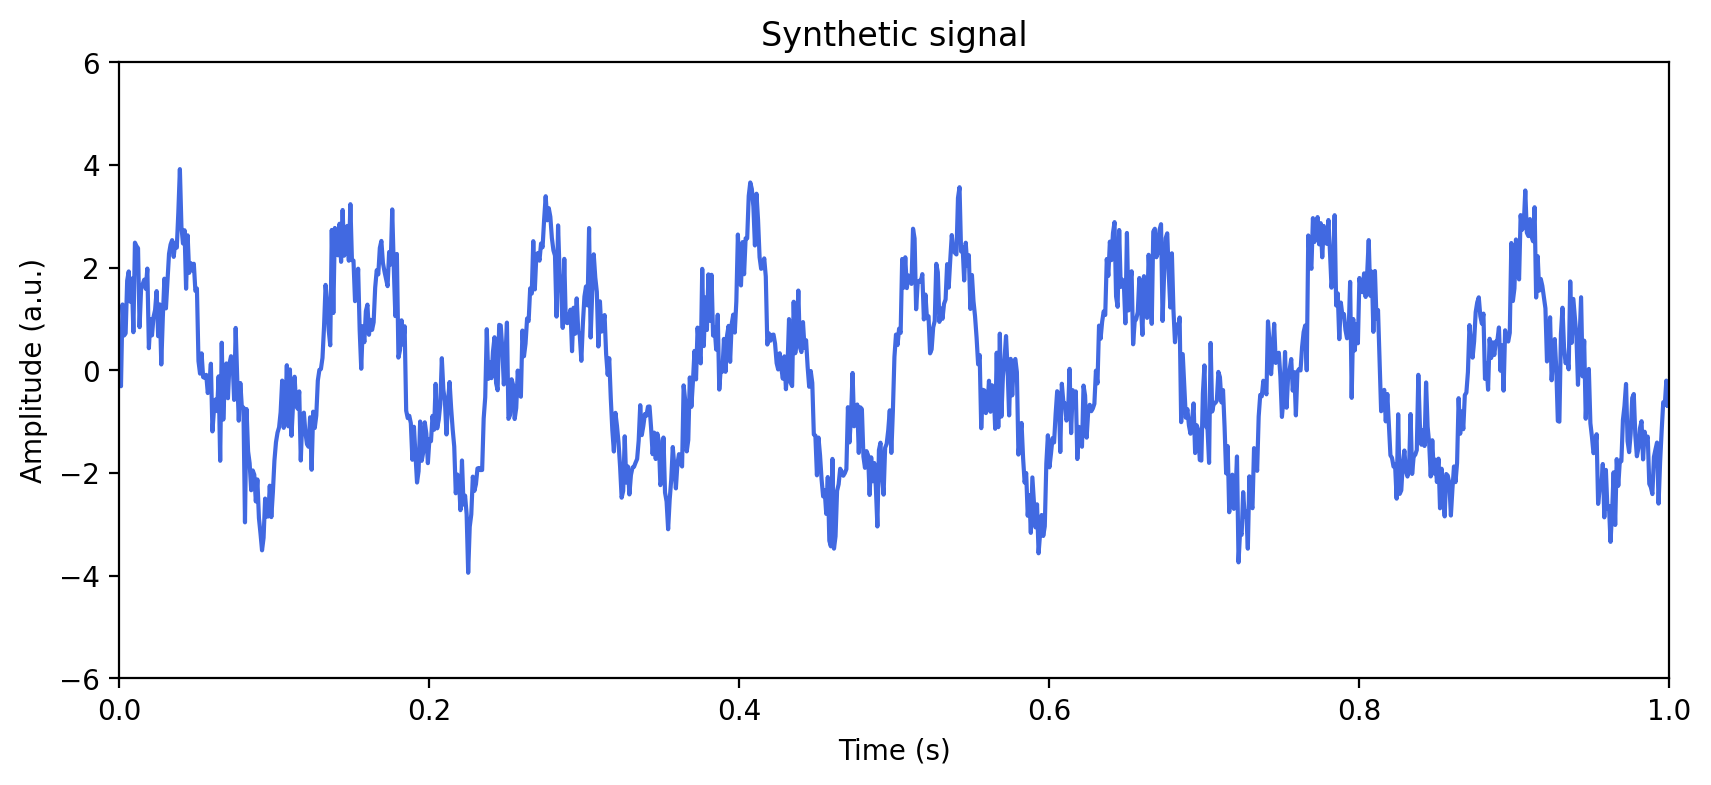

In [146]:
# @title

# @markdown Execute this cell to visualize the data

# Plot the signal
plt.figure(figsize=(10, 4))
plt.title('Synthetic signal')
plt.plot(t, LFP, 'royalblue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.xlim([0, 1])
plt.ylim([-6, 6])
plt.show()

## Interactive Demo 1: Playing with signal parameters

Using an interactive widget, we can visualize how the manually inserted frequencies are present in the signal, how their amplitudes change and the effect of noise in the time series. This, however, is an overly simplistic representation, as the real signals can be decomposed into indefinite (limited by the sampling rate) frequency components.

While decoupling signal from noise in this example is as simple as moving a slider, in the real world it is one of the hardest challenges in neuroscience.

In [147]:
# @title Make sure you execute this cell to enable the widget!

@widgets.interact(freq1=widgets.IntSlider(8, min=1, max=50),
                  freq2=widgets.IntSlider(30, min=1, max=50),
                  amp1=widgets.IntSlider(2, min=1, max=4),
                  amp2=widgets.IntSlider(1, min=1, max=4),
                  noise=widgets.FloatSlider(0.5, min=0, max=1.0))

def plot_data_estimate(freq1, freq2, amp1, amp2, noise):
  t = np.arange(0, 1, 1/fs)
  LFP = amp1 * np.sin(2*np.pi*freq1*t) + amp2 * np.sin(2*np.pi*freq2*t) + np.random.normal(0, noise, len(t))
  plt.figure(figsize=(10, 4))
  plt.plot(t, LFP, 'royalblue')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude (a.u.)')
  plt.xlim([0, 1])
  plt.ylim([-10, 10])
  plt.show()


interactive(children=(IntSlider(value=8, description='freq1', max=50, min=1), IntSlider(value=30, description=…

#### Sampling rate and aliasing

This section will showcase the effects that different sampling rates can produce on the recorded signal, and how it can lead to aliasing.

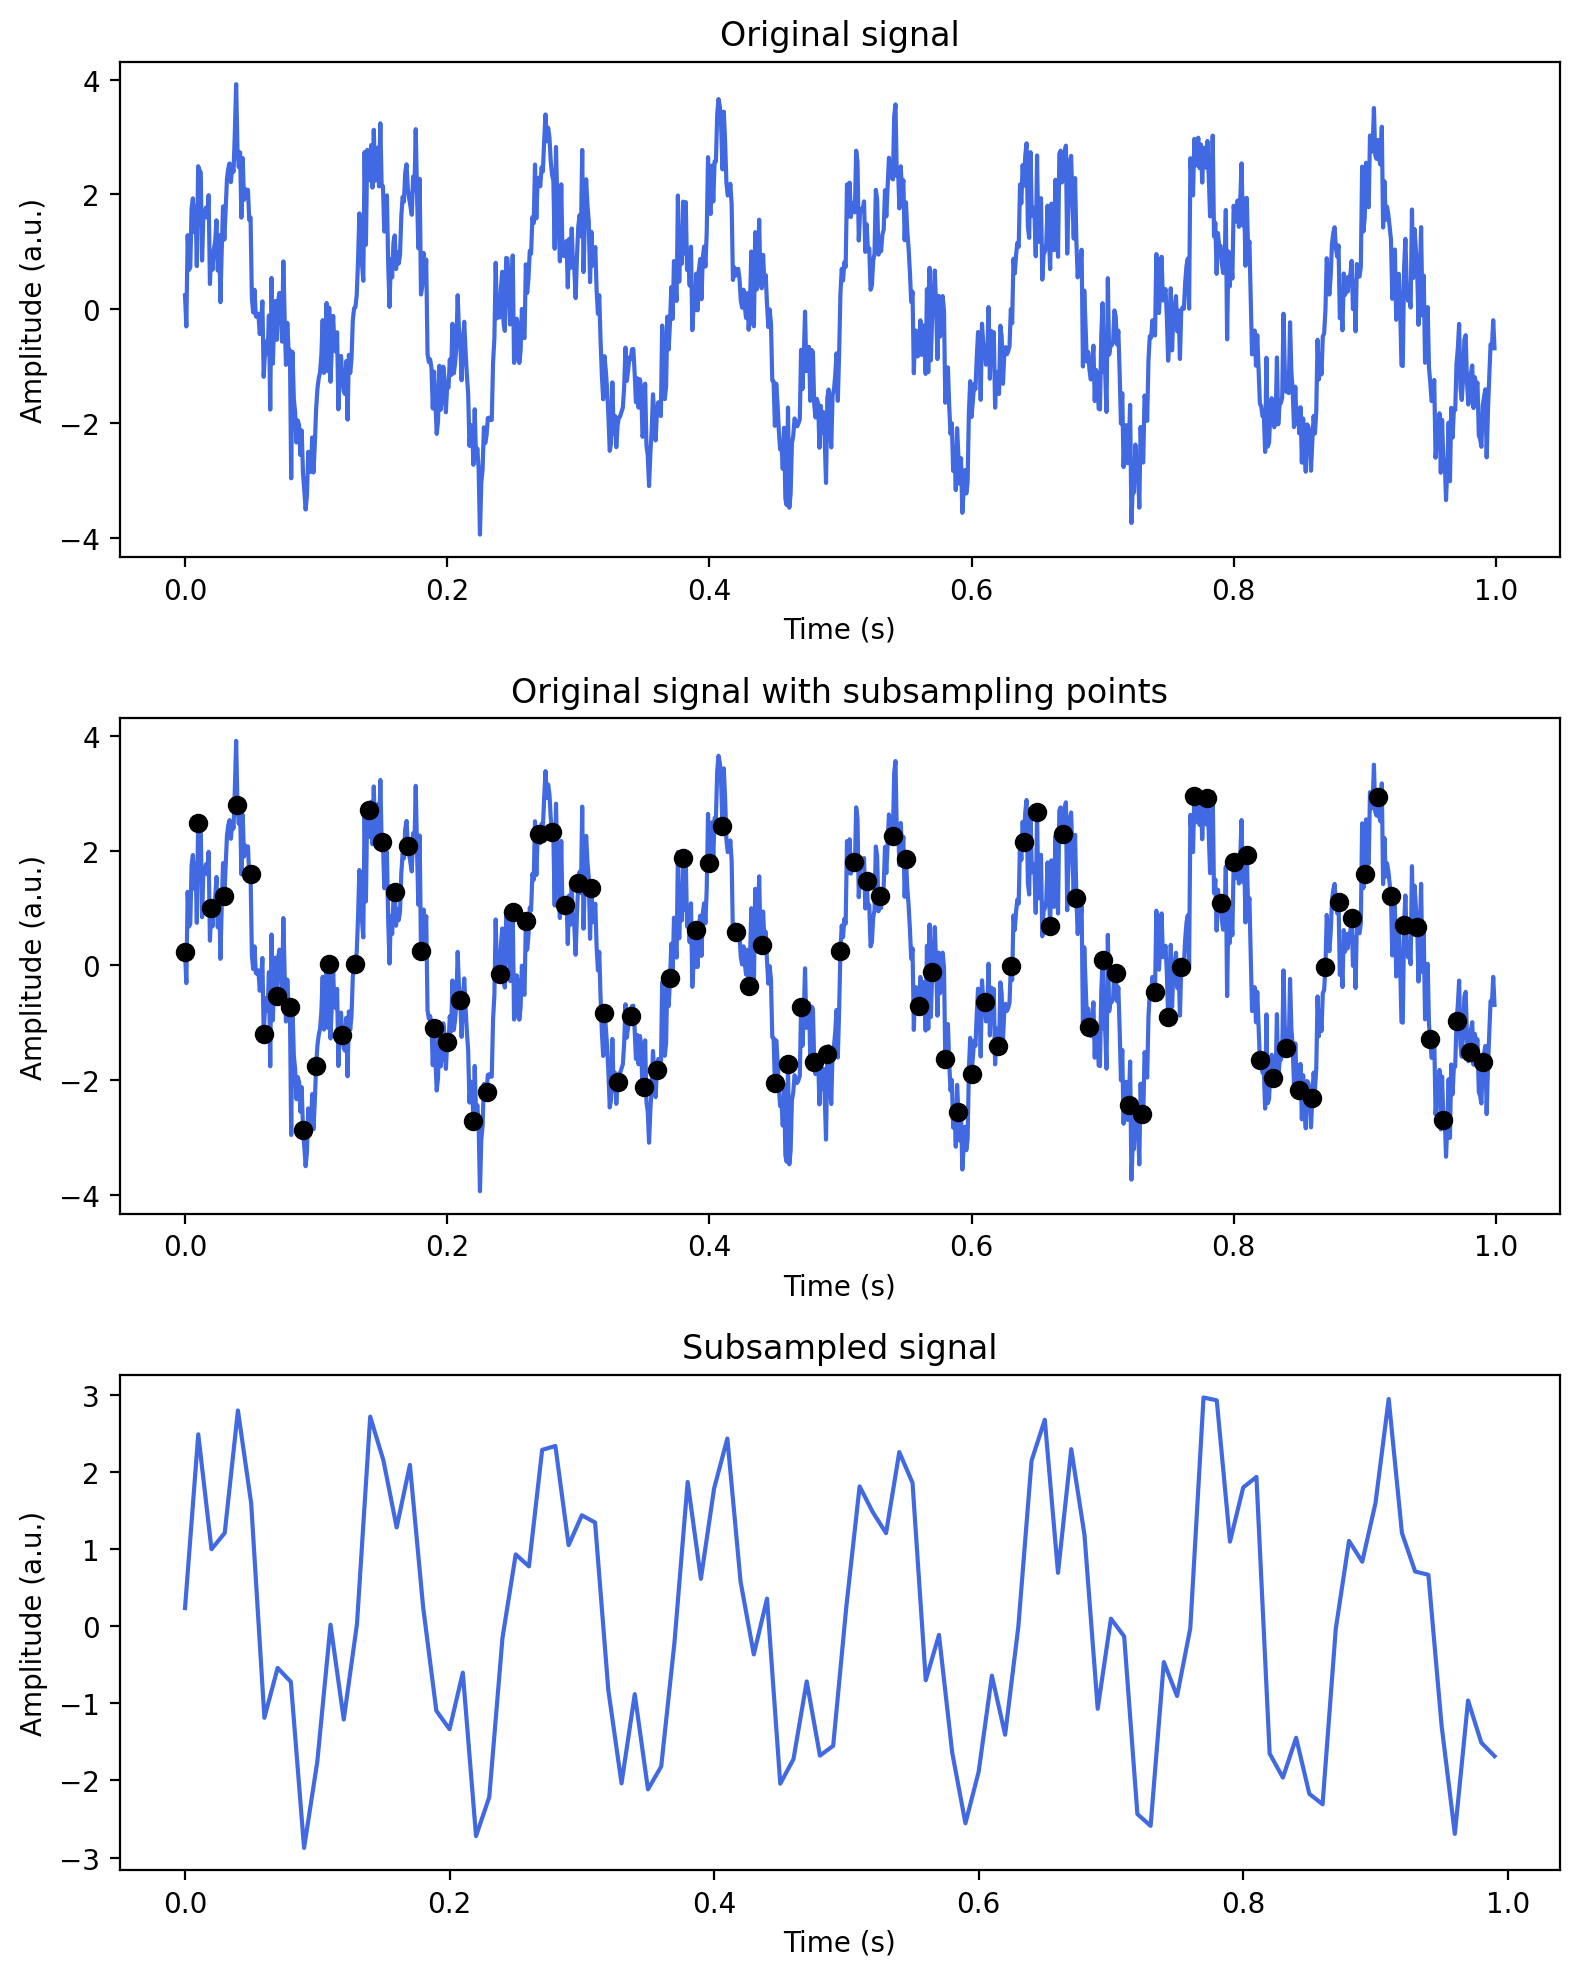

In [148]:
# Create a 3x1 figure
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

# Plot the original signal
axs[0].plot(t, LFP, 'royalblue')
axs[0].set_title('Original signal')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude (a.u.)')

# Subsample the signal at 100 Hz (every 10th sample)
sub_LFP = LFP[::10]
sub_t = t[::10]

# Plot the original signal with subsampling points
axs[1].plot(t, LFP, 'royalblue')
axs[1].plot(sub_t, sub_LFP, 'ko')
axs[1].set_title('Original signal with subsampling points')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude (a.u.)')

# Plot the subsampled signal
axs[2].plot(sub_t, sub_LFP, 'royalblue')
axs[2].set_title('Subsampled signal')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Amplitude (a.u.)')

# Show the figure
plt.tight_layout()
plt.show()


**Aliasing** is a phenomenon in signal processing where a high-frequency signal appears as a lower-frequency signal in the sampled data. This mischaracterization occurs when the sampling rate used to capture a signal is insufficient to accurately represent the original analog signal. Aliasing can lead to a misinterpretation of the true frequency content of the signal and introduce artifacts in the reconstructed signal.

In [149]:
# @title An interactive widget with sliders for frequency and subsampling rate
@widgets.interact(freq=widgets.IntSlider(2, min=1, max=20),
                  subsample_rate=widgets.IntSlider(100, min=2, max=100))

def plot_data_estimate(freq, subsample_rate):
  # Generate the time vector
  t = np.arange(0, 1, 1/fs)

  # Generate the original signal
  LFP = np.sin(2*np.pi*freq*t)

  # Subsample the signal
  sub_LFP = LFP[::int(fs/subsample_rate)]
  sub_t = t[::int(fs/subsample_rate)]


  # Create a 3x1 figure
  fig, axs = plt.subplots(3, 1, figsize=(7, 7))

  # Plot the original signal
  axs[0].plot(t, LFP, 'royalblue')
  axs[0].set_title('Original signal')
  axs[0].set_xlabel('Time (s)')
  axs[0].set_ylabel('Amplitude (a.u.)')

  # Plot the original signal with subsampling points
  axs[1].plot(t, LFP, 'royalblue')
  axs[1].plot(sub_t, sub_LFP, 'ko')
  axs[1].set_title('Original signal with subsampling points')
  axs[1].set_xlabel('Time (s)')
  axs[1].set_ylabel('Amplitude (a.u.)')

  # Plot the subsampled signal
  axs[2].plot(sub_t, sub_LFP, 'royalblue')
  axs[2].set_title('Subsampled signal')
  axs[2].set_xlabel('Time (s)')
  axs[2].set_ylabel('Amplitude (a.u.)')

  # Show the figure
  plt.tight_layout()
  plt.show()


interactive(children=(IntSlider(value=2, description='freq', max=20, min=1), IntSlider(value=100, description=…

When a continuous analog signal is sampled at a certain rate, it is converted into a discrete signal by capturing its amplitude at regular intervals. The Nyquist-Shannon sampling theorem states that to avoid aliasing, the sampling rate must be at least twice the frequency of the highest component in the signal. This critical frequency is known as the **Nyquist frequency**.

#### Mitigation Strategies:

To mitigate aliasing, it is crucial to adhere to the Nyquist sampling criterion by choosing an appropriate sampling rate. If the frequency of a signal exceeds half of the sampling rate, a low-pass anti-aliasing filter can be employed before sampling to remove high-frequency components. This ensures that signals are accurately represented in the digital domain and prevents the introduction of misleading oscillations.


## Signal artifacts

### Introducing Artifacts and Artifact Corrections

In our exploration, we will intentionally introduce some artifacts into our synthetic signal to observe their impact and subsequently apply artifact correction techniques. Artifacts manifest as undesired features in a signal, such as an overall increase in amplitude, non-stationarity*, or the presence of fixed power in spurious frequencies.



We will start by generating 5 synthetic signals, which will be our "channels".

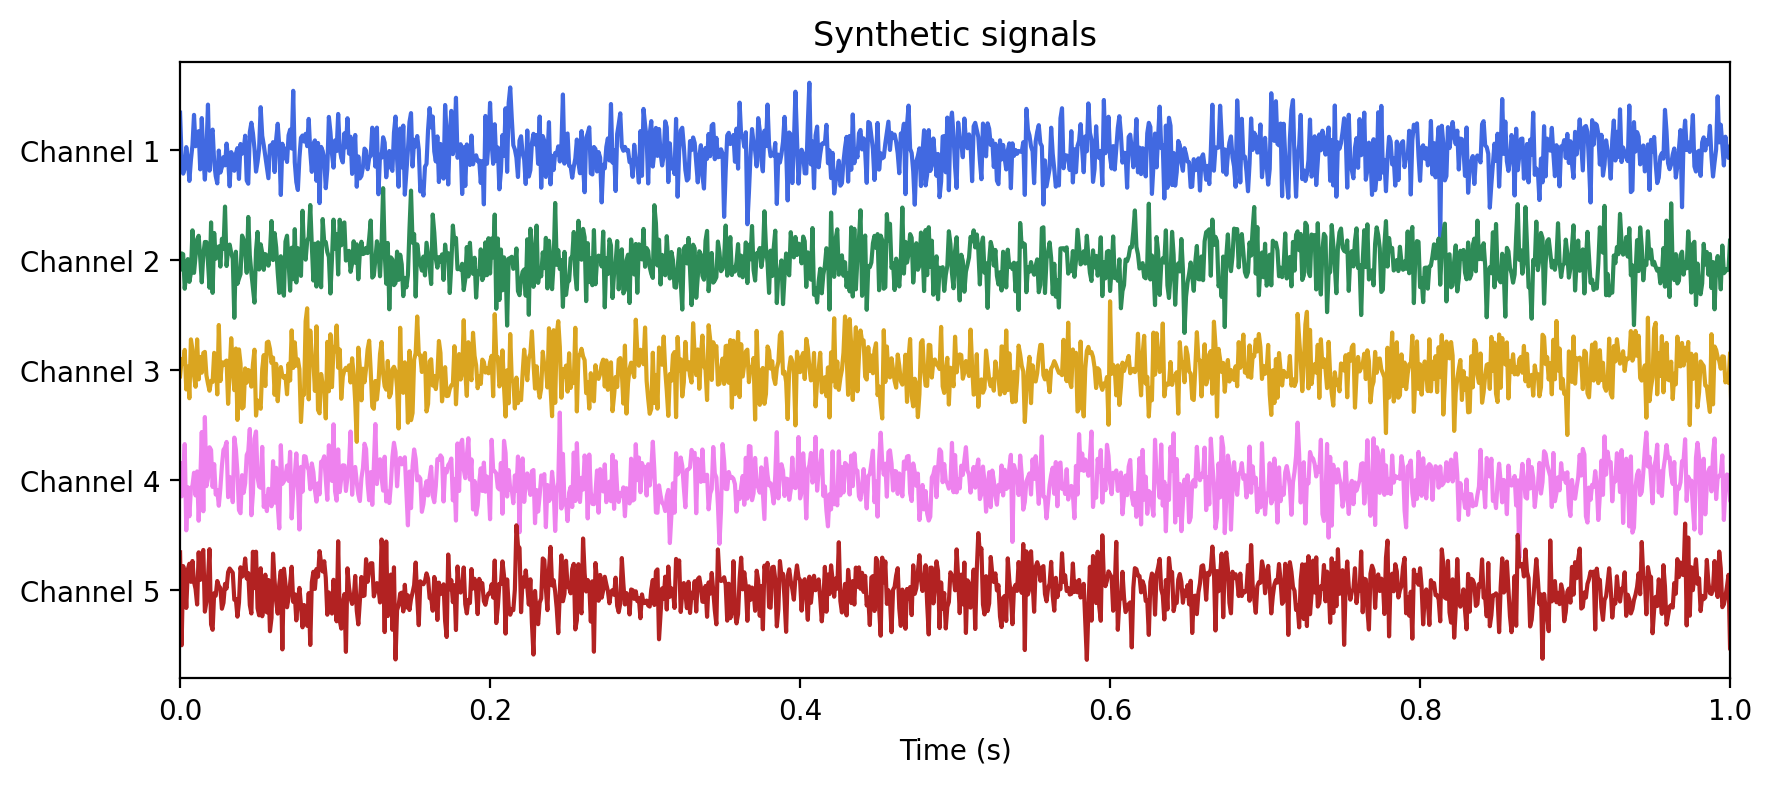

In [150]:
from cycler import cycler

# Define your custom color cycle
colors = ['royalblue', 'seagreen', 'goldenrod', 'violet', 'firebrick']
custom_cycler = cycler(color=colors)

t = np.arange(0, 10, 1/fs)
n_trials = 5
# Generate signals in an array
signals = np.zeros((n_trials, len(t)))
v_shift = 2.5  # vertical shift between signals

# Initialize the frequency vector
frequencies = np.arange(0.1, 100, 0.1)
# Initialize the amplitude vector (for simplicity, we will assume that the amplitudes are the inverse of the frequencies)
amplitudes = 1 / frequencies


for i in range(5):
  # assign a random amplitude between 1 and 5
  amp = amplitudes[np.random.randint(0, len(frequencies))]
  # assign a random frequency between 1 and 100
  freq = frequencies[np.random.randint(0, len(frequencies))]
  # generate signal
  signals[i, :] = (amp * np.sin(2*np.pi*freq*t) + amp * np.sin(2*np.pi*freq*t) + np.random.normal(0, 0.5, len(t))) + v_shift * (4 - i)  # add noise and a constant value to separate signals

# Plot the signals without overlaying them
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_prop_cycle(custom_cycler)
plt.title('Synthetic signals')
plt.plot(t, signals.T)  # Use the fixed colors for each signal
plt.xlabel('Time (s)')
plt.xlim([0, 1])
plt.ylim([-2, 12])  # Adjust y-axis limit to accommodate the constant values
plt.yticks(np.arange(0, 12, v_shift), labels=[f'Channel {5-i}' for i in range(5)])  # Add yticks related to each channel
plt.show()


#### Common Types of Artifacts

1. **Overall Increase in Amplitude:**
   - This artifact is characterized by a global rise in signal amplitude, often obscuring the underlying patterns of interest.
   - Most of the time, this happens due to behaviours outside the scope of the analysed phenomena, such as blinking, motor activity, etc.
   
2. **Non-Stationarity:**
   - Non-stationarity refers to variations in the statistical properties of the signal over time. These variations can hinder the accurate analysis of underlying dynamics.

3. **Fixed Power in Spurious Frequencies:**
   - Artifacts may introduce power at specific frequencies unrelated to the natural frequency content of the signal, leading to misleading interpretations.

In [151]:
# Adding artifacts to the data

# Increase the amplitude of the third signal from 2.5 s to 4.5 s
signals[2, int(2.5*fs):int(4.5*fs)] = signals[2, int(2.5*fs):int(4.5*fs)] + 4

# Create a trend (linear increase) in signal 4
signals[3, :] = signals[3, :] + np.linspace(0, 10, len(t))

# Increase the power of 60Hz in all signals from 5.5 s to 5.9 s
signals[:, int(5.5*fs):int(5.9*fs)] += 0.5*np.sin(2*np.pi*60*t[int(5.5*fs):int(5.9*fs)])


Visualizing the data after artifact insertions.

In [152]:
# @title Visualize the data with artifacts second by second
@widgets.interact(t=widgets.IntSlider(0, min=0, max=9))
def plot_data_artifacts(t):
  plt.figure(figsize=(10, 4))

  # Define the time range for one second
  time_range = np.arange(t, t+1, 1/fs)

  # Compute the min and max values within the current time range
  min_value = np.min(signals[:, int(t*fs):int((t+1)*fs)])
  max_value = np.max(signals[:, int(t*fs):int((t+1)*fs)])

  # Plot each signal in the time range
  for i in range(signals.shape[0]):
    plt.plot(time_range, signals[i, int(t*fs):int((t+1)*fs)], color=colors[i], label=f'Channel {i+1}')

  plt.xlabel('Time (s)')
  plt.xlim([t, t+1])
  plt.ylim([min_value-1, max_value+1])
  plt.gca().set_yticklabels([])  # Remove yticklabels
  plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
  plt.show()

interactive(children=(IntSlider(value=0, description='t', max=9), Output()), _dom_classes=('widget-interact',)…

### Artifact Corrections

Several techniques can be employed to mitigate the impact of artifacts and restore the integrity of the signal:

#### 1. Notch Filter:
   - **Purpose:** Target and eliminate power at specific frequencies, often associated with external interference.
   - **Implementation:** Use notch filters to suppress unwanted frequency components.

#### 2. Detrending:
   - **Purpose:** Remove long-term trends or baseline shifts in the signal.
   - **Implementation:** Apply detrending algorithms to eliminate slow-varying components.

#### 3. Removing Defective Channels:
   - **Purpose:** Address artifacts originating from specific recording channels.
   - **Implementation:** Identify and exclude channels with significant artifacts from further analysis.

Notch filtering.

In [153]:
# Import the necessary library
import scipy.signal as signal

# Initialize the filtered signals array
filtered_signals = np.zeros(signals.shape)

# Applying a notch filter to remove line (60Hz) noise

# Define the notch filter function
def notch_filter(data, fs, freq, Q=30):
    w0 = freq/(fs/2) # Normalized Frequency
    b, a = signal.iirnotch(w0, Q) # Q is the quality factor
    filtered_data = signal.filtfilt(b, a, data) # Apply the notch filter

    return filtered_data

# Apply the notch filter to each channel
for i in range(signals.shape[0]):
    filtered_signals[i, :] = notch_filter(signals[i, :], fs, freq=60) # Freq is the frequency to be removed

Detrending a signal.

In [154]:
# Apply the detrending function to the 4th channel
filtered_signals[3,:] = signal.detrend(signals[3, :]) + v_shift * 1

Removing a bad channel.

In [155]:
# Remove the 3rd channel from the filtered signals array
filtered_signals = np.delete(filtered_signals, 2, axis=0)
# Remove the corresponding color
colors.pop(2)  # Remove the color corresponding to the 4th signal

'goldenrod'

Visualize the data after artifact removal.

In [156]:
# @title Visualize the data with artifacts second by second
@widgets.interact(t=widgets.IntSlider(0, min=0, max=9))
def plot_data_artifacts(t):
  plt.figure(figsize=(10, 4))

  # Define the time range for one second
  time_range = np.arange(t, t+1, 1/fs)

  # Compute the min and max values within the current time range
  min_value = np.min(filtered_signals[:, int(t*fs):int((t+1)*fs)])
  max_value = np.max(filtered_signals[:, int(t*fs):int((t+1)*fs)])

  # Plot each signal in the time range

  for i in range(filtered_signals.shape[0]):
    if i > 1:
        plt.plot(time_range, filtered_signals[i, int(t*fs):int((t+1)*fs)], color=colors[i], label=f'Channel {i+2}')
    else:
        plt.plot(time_range, filtered_signals[i, int(t*fs):int((t+1)*fs)], color=colors[i], label=f'Channel {i+1}')

  plt.xlabel('Time (s)')
  plt.xlim([t, t+1])
  plt.ylim([min_value-1, max_value+1])
  plt.gca().set_yticklabels([])  # Remove yticklabels
  plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
  plt.show()

interactive(children=(IntSlider(value=0, description='t', max=9), Output()), _dom_classes=('widget-interact',)…

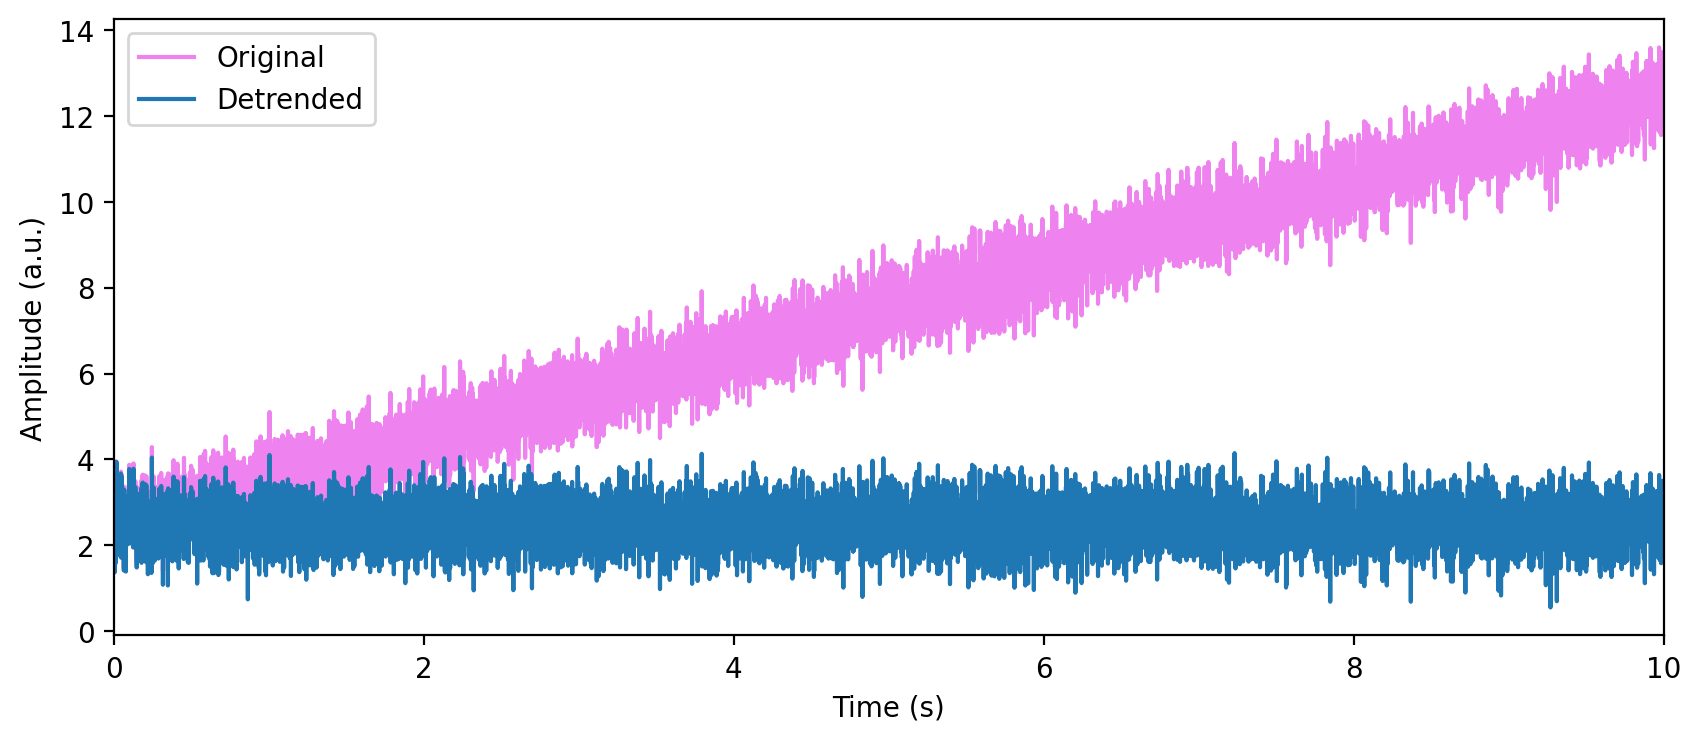

In [157]:
# Plot the 4th signal before and after detrending
plt.figure(figsize=(10, 4))
plt.plot(t, signals[3, :], label='Original', color=colors[2])
plt.plot(t, filtered_signals[2, :], label='Detrended')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.xlim([0, 10])
plt.legend()
plt.show()

---
# Section 2: Transforming a time series into the frequency domain

*Estimated timing to here from start of tutorial: 20 min*

In this section, we will explore the transformation of temporal LFP signals into the frequency domain. Understanding the frequency composition of neural signals is crucial for uncovering patterns and extracting meaningful information from the data.

Procedure:

**Signal Transformation:**

Utilize Fourier transforms to convert temporal signals into the frequency domain.

**Power Spectral Density (PSD):**
Calculate and visualize the Power Spectral Density to understand the distribution of signal power across different frequencies.

**Interpretation:**
Gain insights into the frequency components that dominate the LFP signals.

## Loading real data from .mat files

The file LFPprobe.mat contains simultaneous recordings of 16 LFP channels from a NeuroNexus vertical linear probe, with electrodes ranging from the parietal cortex to the hippocampus, spaced by 100µm.

In [158]:
# Import the necessary library
from scipy.io import loadmat
# Load the data from the .mat file
probe_data = loadmat('LFPprobe.mat')

Inspecting the data.

In [159]:
# Explore the data
print(probe_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'LFPprobe', 'srate'])


Loading the data.

In [160]:
probe_fs = probe_data['srate'].squeeze()  # Extract the sampling rate of the probe data
probe_LFP = probe_data['LFPprobe']  # Extract the LFP data from the probe

print(f"The sampling rate of the probe data is {fs} Hz")  # Print the sampling rate of the probe data
print(f"The shape of the probe data is {probe_LFP.shape}")  # Print the shape of the probe data

The sampling rate of the probe data is 1000 Hz
The shape of the probe data is (16, 375038)


### Computing the PSD using Welch's method

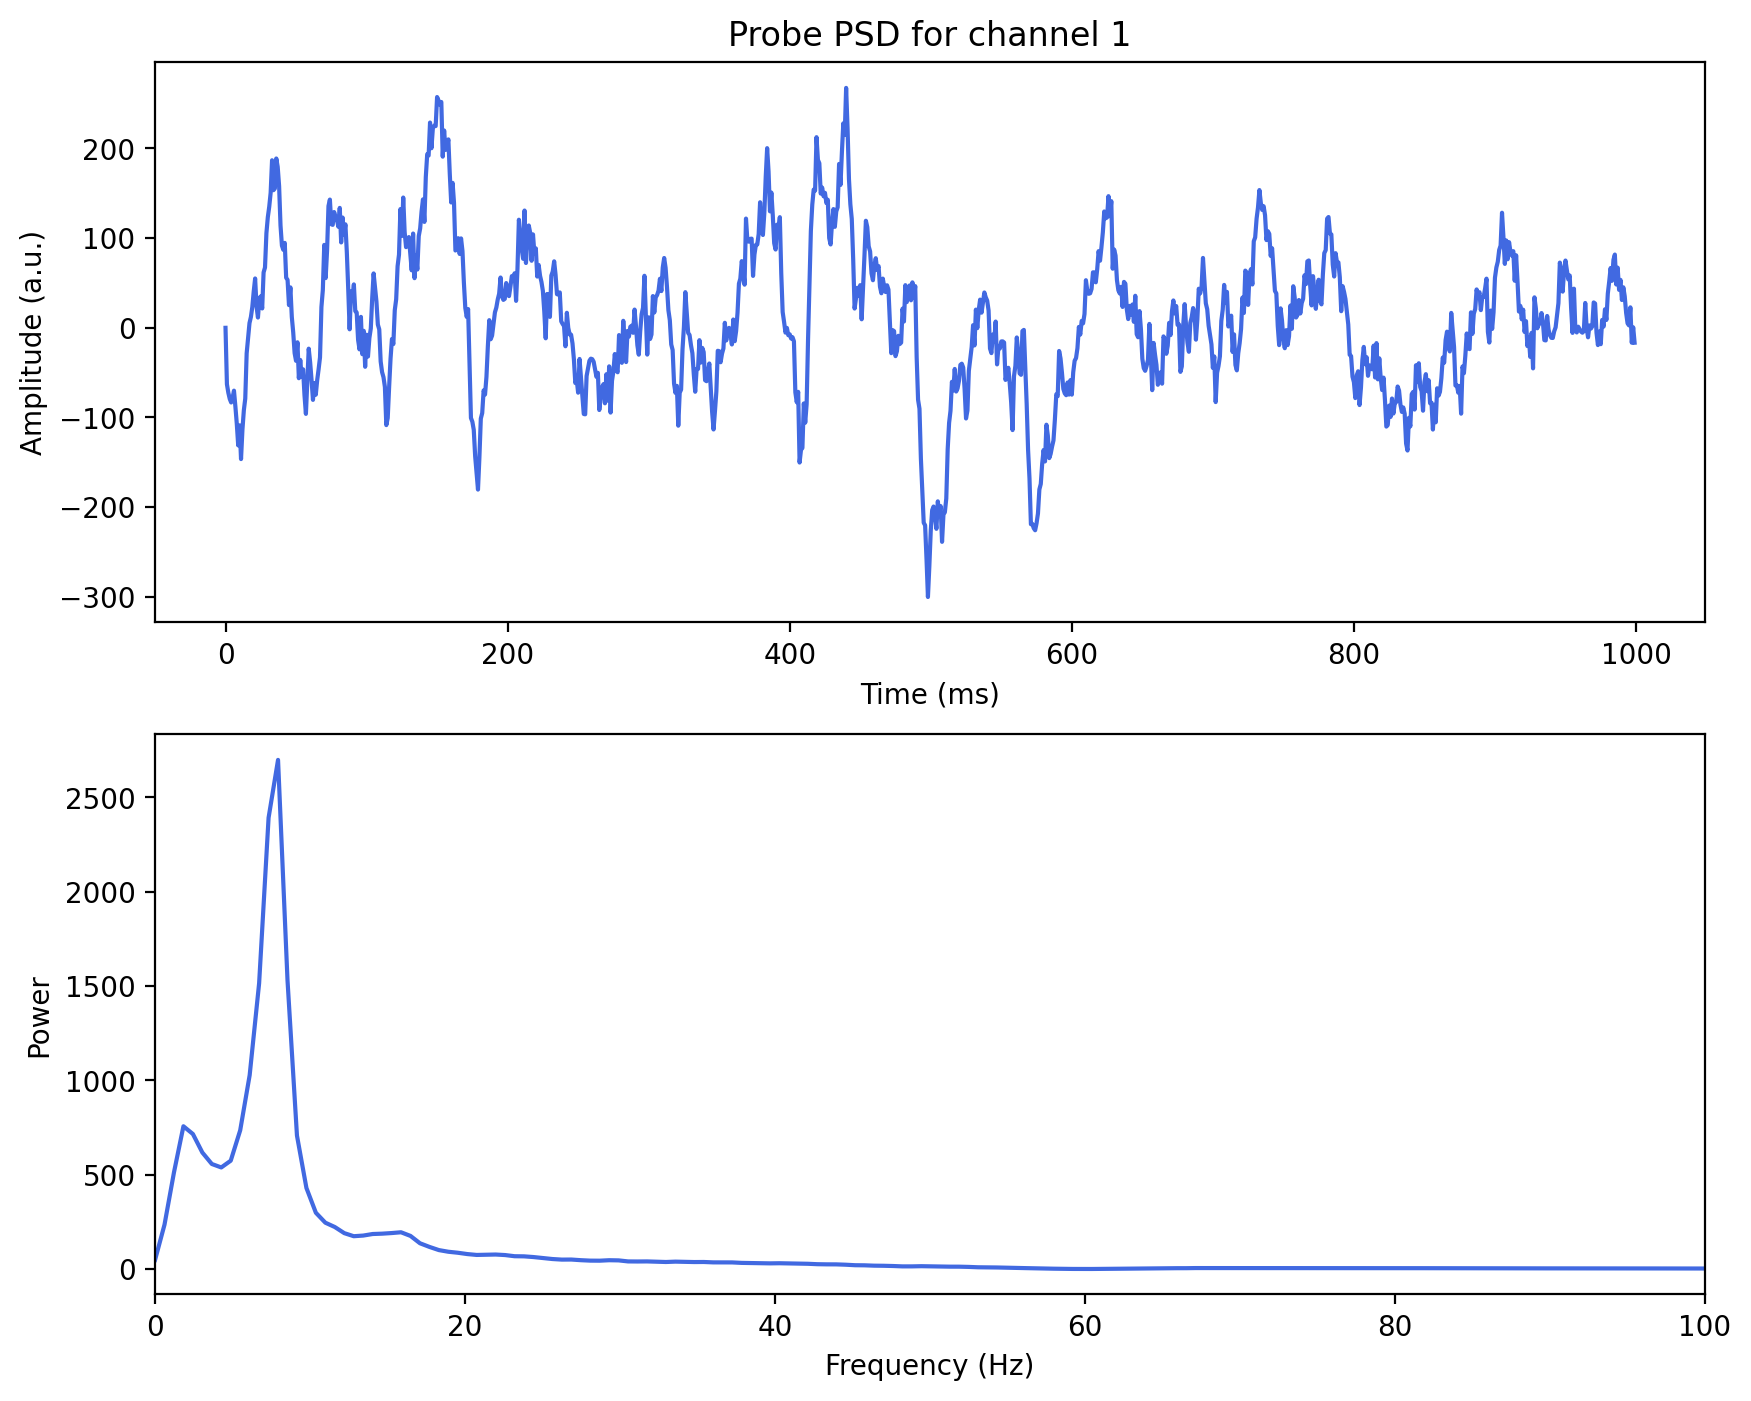

In [161]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title('Probe PSD for channel 1')
plt.plot(probe_LFP[0, 0:1000], 'royalblue')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (a.u.)')

plt.subplot(2, 1, 2)
probe_freqs, probe_psd = signal.welch(probe_LFP[0, :], fs=probe_fs, nperseg=1024)
plt.plot(probe_freqs, probe_psd, color='royalblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim([0, 100])
plt.show()

Now doing it for all 16 channels of the probe.

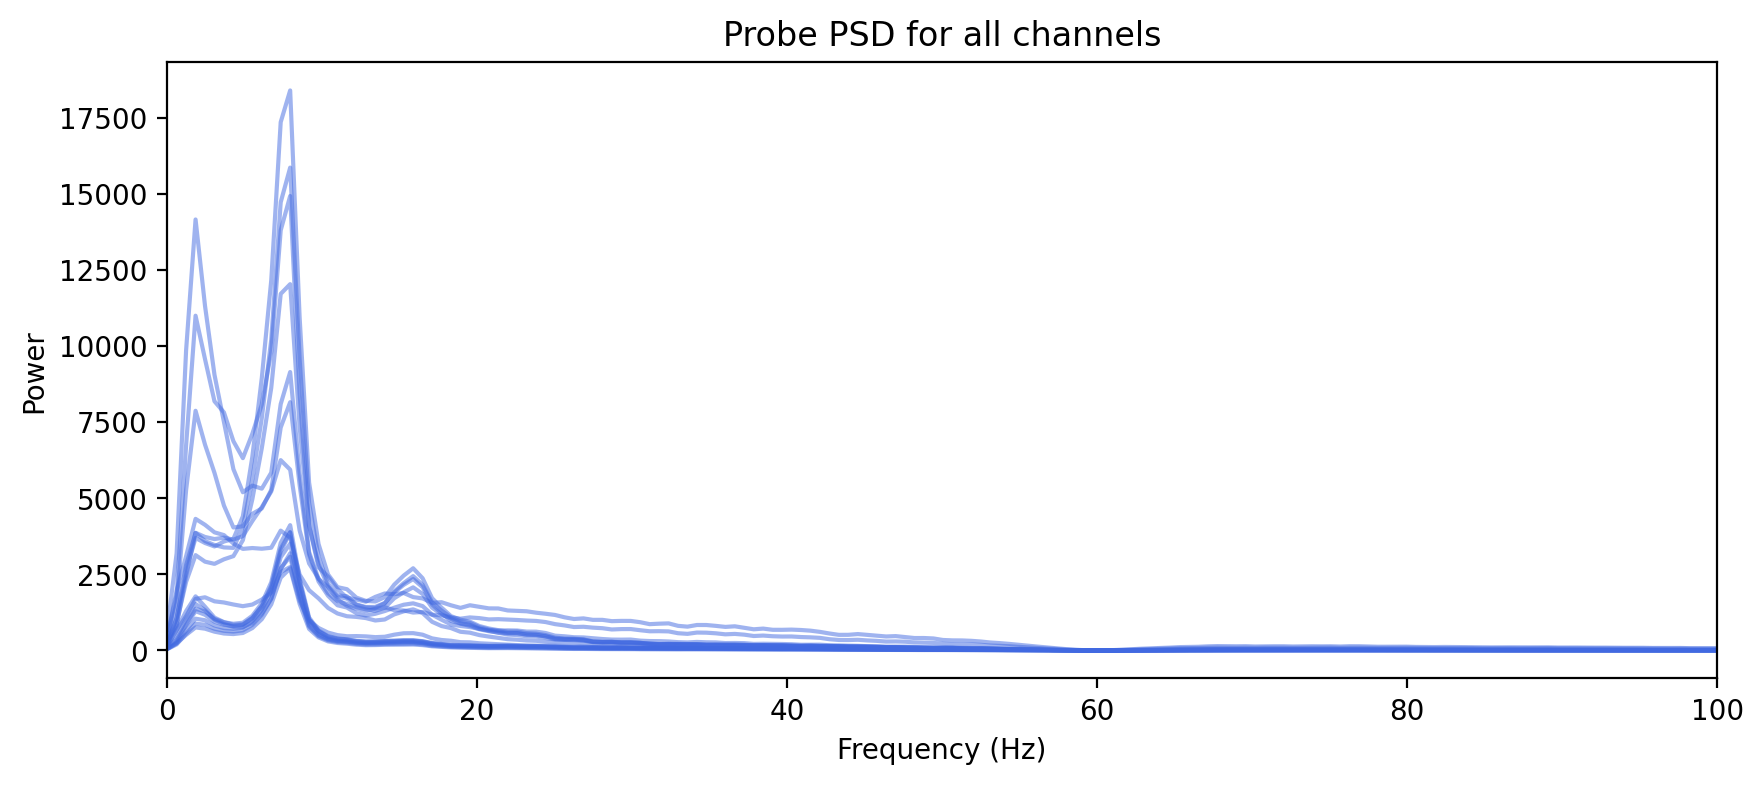

In [162]:
probe_freqs, probe_psd = signal.welch(probe_LFP, fs=probe_fs, nperseg=1024)

plt.figure(figsize=(10, 4))
plt.title('Probe PSD for all channels')
plt.plot(probe_freqs, probe_psd.T, color='royalblue', alpha=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim([0, 100])
plt.show()

#### Normalizations

Normalization can be a crucial step in signal processing that enhances the comparability of PSDs across different channels or experiments.

The code below demonstrates three common normalization approaches applied to the PSD of probe Local Field Potential (LFP) signals:

1. **Standard Normalization:**
   - Normalizes the PSD by dividing each channel's power by its maximum power, providing a relative comparison of power levels.

2. **dB Normalization:**
   - Utilizes logarithmic scaling (dB) to normalize the PSD, enhancing visibility of power differences especially at lower values.

3. **Z-scoring:**
   - Z-scores the PSD, transforming it to a standard normal distribution by subtracting the mean and dividing by the standard deviation for each channel.

Explore how these normalization techniques can change the visualization of the signal.

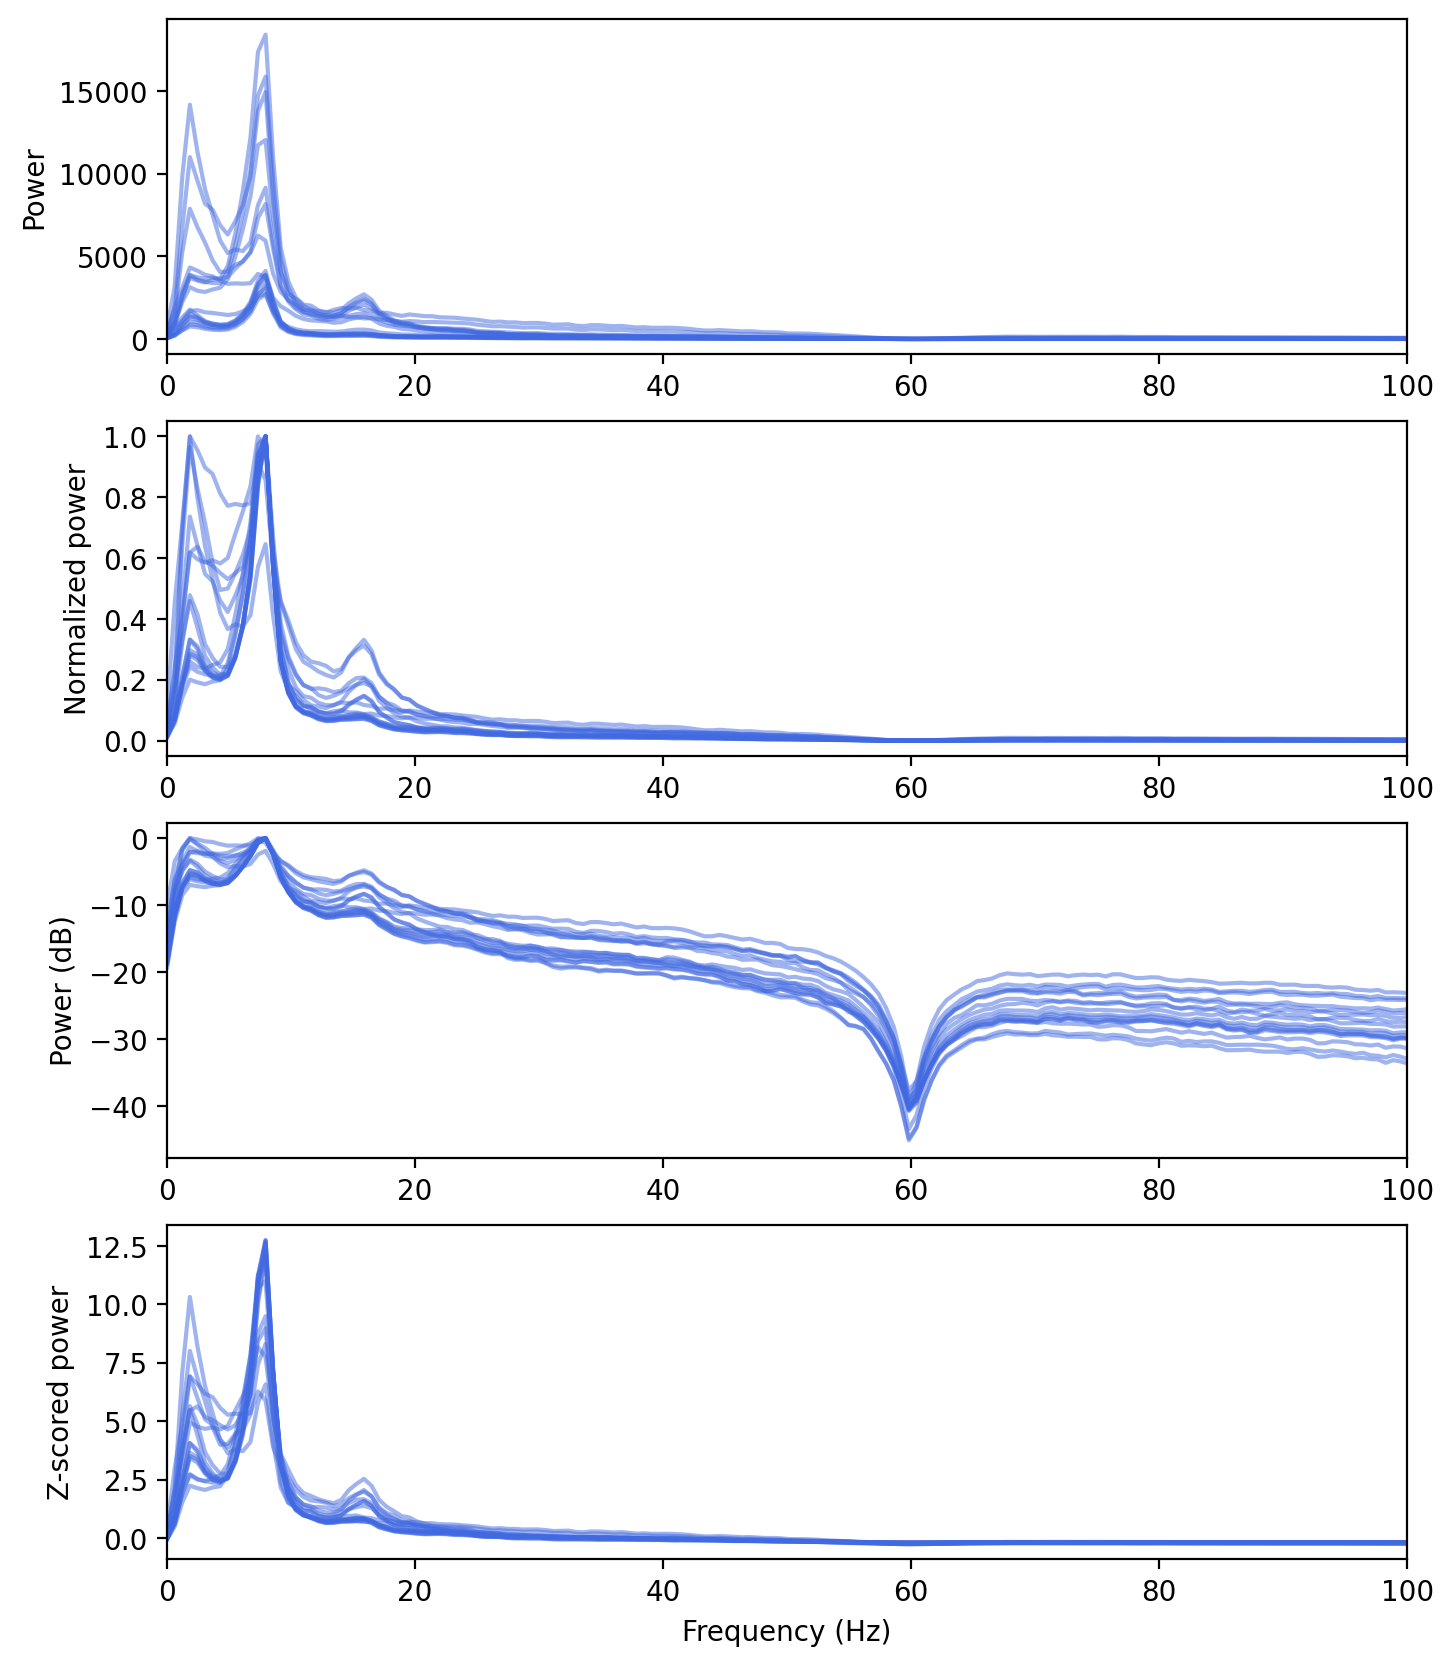

In [163]:
probe_freqs, probe_psd = signal.welch(probe_LFP, fs=probe_fs, nperseg=1024)

plt.figure(figsize=(8, 10))

plt.subplot(4, 1, 1)  # Original Probe PSD for all channels
plt.plot(probe_freqs, probe_psd.T, color='royalblue', alpha=0.5)
plt.ylabel('Power')
plt.xlim([0, 100])

plt.subplot(4, 1, 2)  # Standard Normalization
plt.plot(probe_freqs, probe_psd.T / np.max(probe_psd, axis=1), color='royalblue', alpha=0.5)
plt.ylabel('Normalized power')
plt.xlim([0, 100])

plt.subplot(4, 1, 3)  # dB Normalization
plt.plot(probe_freqs, 10 * np.log10(probe_psd.T / np.max(probe_psd, axis=1)), color='royalblue', alpha=0.5)
plt.ylabel('Power (dB)')
plt.xlim([0, 100])

plt.subplot(4, 1, 4)  # Z-scoring
plt.plot(probe_freqs, (probe_psd.T - np.mean(probe_psd, axis=1)) / np.std(probe_psd, axis=1), color='royalblue', alpha=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Z-scored power')
plt.xlim([0, 100])

plt.show()

### The PSD usually varies with time

Acknowledging that the Power Spectral Density (PSD) of neural signals typically varies over time is crucial. This variation forms the basis for the upcoming Time-Frequency Analysis section, where we introduce methods to capture and interpret the dynamic changes in frequency content.

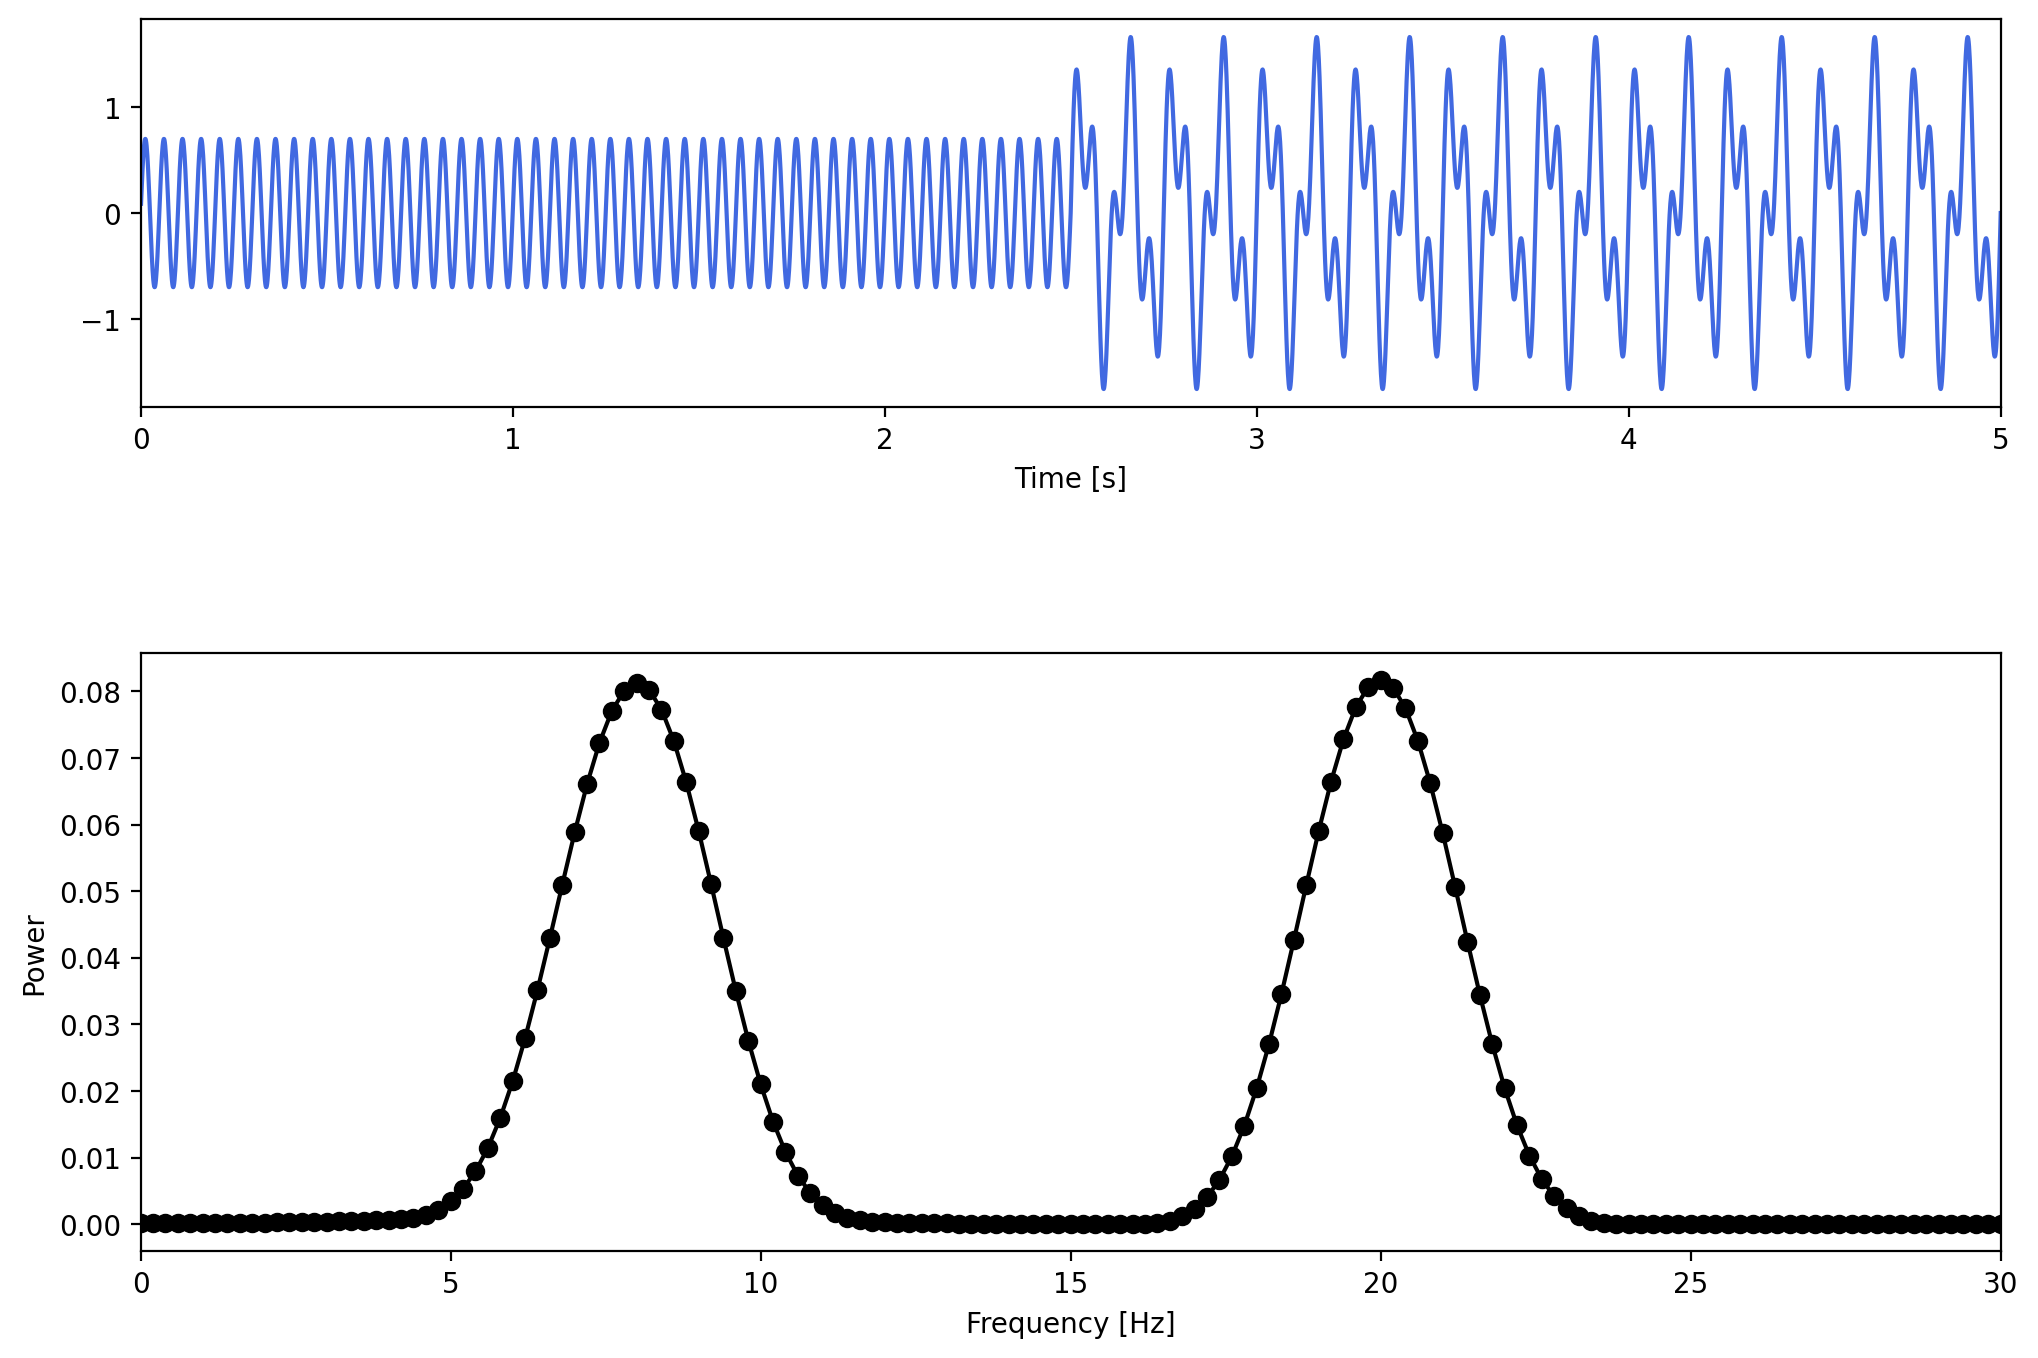

In [164]:
# Power spectral density of an artificial signal

fs = 1000.  # Sampling frequency
dt = 1./fs  # Time step
t = np.arange(dt,5.00001,dt)  # Time array

LFP = np.sin(2*np.pi*8*t)  # Generate artificial signal
LFP[:2500] = 0  # Set initial portion to 0
LFP = LFP + 0.7*np.sin(2*np.pi*20*t)  # Add another sinusoid

plt.figure(figsize=(12,8))  # Create a figure
ax1 = plt.subplot2grid((6,1),(0,0),rowspan=2)  # Define subplot for time series
ax1.plot(t,LFP, color='royalblue')  # Plot the artificial signal
ax1.set_xlabel('Time [s]')  # Set x-axis label
ax1.set_xlim([0,5])  # Set x-axis limits

win = 0.5*fs  # Define window length
overlap = 0.5*win  # Define overlap
nfft = 5000  # Define number of FFT points

F,Pxx = signal.welch(LFP,fs,nperseg=win,noverlap=overlap,nfft=nfft)  # Compute Welch's method

ax2 = plt.subplot2grid((6,1),(3,0),rowspan=3)  # Define subplot for power spectral density
ax2.plot(F,Pxx,'ko-')  # Plot the power spectral density
ax2.set_xlabel('Frequency [Hz]')  # Set x-axis label
ax2.set_ylabel('Power')  # Set y-axis label
ax2.set_xlim([0,30])  # Set x-axis limits
plt.show()  # Display the plot


---
# Section 3: Time-Frequency Analyses

*Estimated timing to here from start of tutorial: 30 min*

This section focuses on computing spectrograms, revealing the time-frequency profile of spectral power in LFP data. Spectrograms provide a dynamic view of neural activity, allowing us to uncover patterns that evolve over time.

Procedure:

**Spectrogram Calculation:**
Utilize time-frequency analysis techniques to compute the spectrogram of LFP signals.

**Visualization:**
Create visualizations that represent the time-dependent changes in spectral power.

Let's start be computing and visualizing a spectrogram of the signal we just saw at the end of section 2.

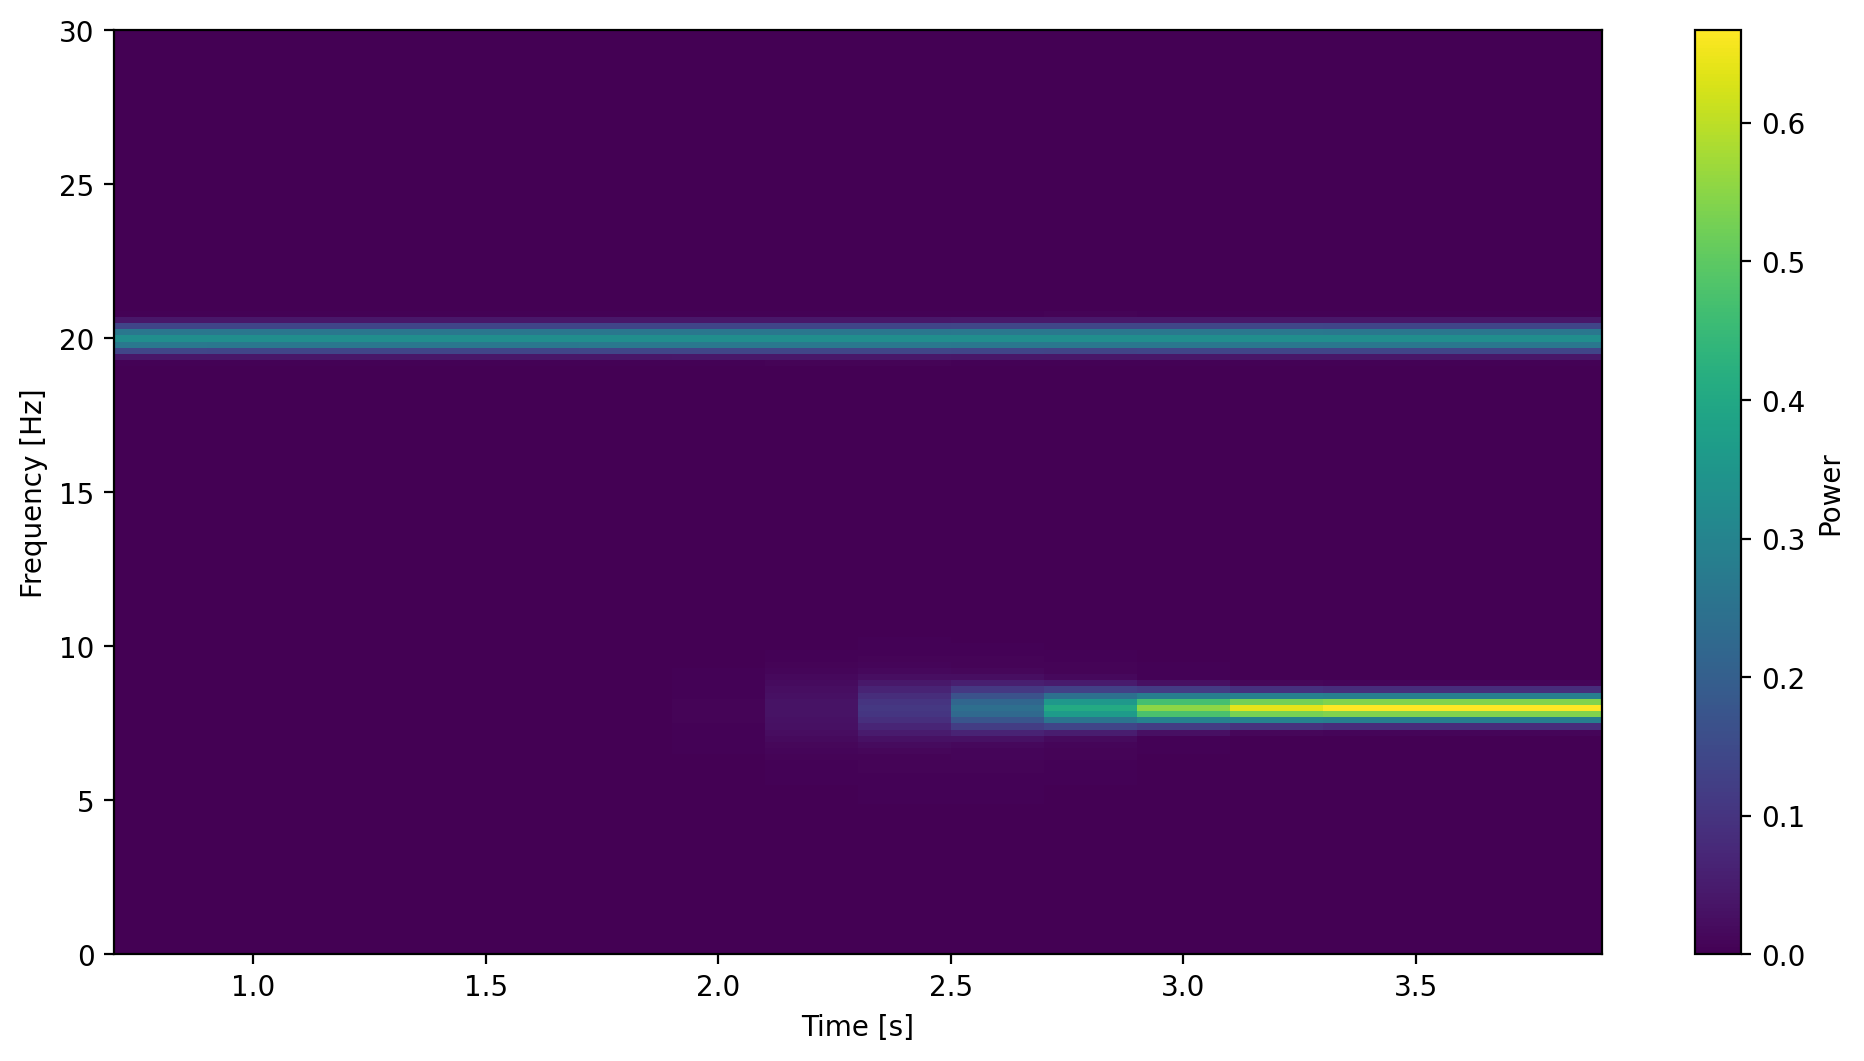

In [165]:
windowlen = int(2.*fs)      # Define window length in seconds
stepsize  = int(0.1*windowlen) # Calculate percentage of overlapping
Nwindows  = int((len(LFP)-windowlen)/stepsize+1)  # Calculate the number of windows

T = np.empty(Nwindows)  # Initialize array to store time values
TFD = np.empty((Nwindows,round(len(t)/2+1)))  # Initialize array to store time-frequency data
for nwin in range(Nwindows):  # Iterate over each window
    winsample = np.arange(windowlen) + (nwin-1)*stepsize  # Define the sample window
    F,Pxx = signal.welch(LFP[winsample],fs=fs,nperseg=windowlen,nfft=nfft)  # Compute Welch's method
    T[nwin] = t[int(winsample[int(windowlen/2)])]  # Store the time value
    TFD[nwin,:] = Pxx  # Store the power spectral density

plt.figure(figsize=(12,6))  # Create a figure for the spectrogram
plt.pcolormesh(T,F,TFD.T)  # Plot the spectrogram
plt.ylim([0,30])  # Set the y-axis limit
plt.xlabel('Time [s]')  # Set the x-axis label
plt.ylabel('Frequency [Hz]')  # Set the y-axis label
plt.colorbar(label='Power')  # Add colorbar
plt.show()


### Visualizing the frequency power changes through time

In [166]:
# @markdown Make sure you execute this cell to enable the widget!
@widgets.interact(time=widgets.IntSlider(0, min=0, max=TFD.shape[0]-1, step=1))
def update_plot(time):
    plt.figure(figsize=(10,5))
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power')
    plt.plot(F,TFD[int(time),:])
    plt.xlim([0,30])
    plt.ylim([0,1])
    plt.title('Time = '+str(T[time])+' s')
    plt.show()



interactive(children=(IntSlider(value=0, description='time', max=15), Output()), _dom_classes=('widget-interac…

Now simply using the spectrogram function from scipy.signal.

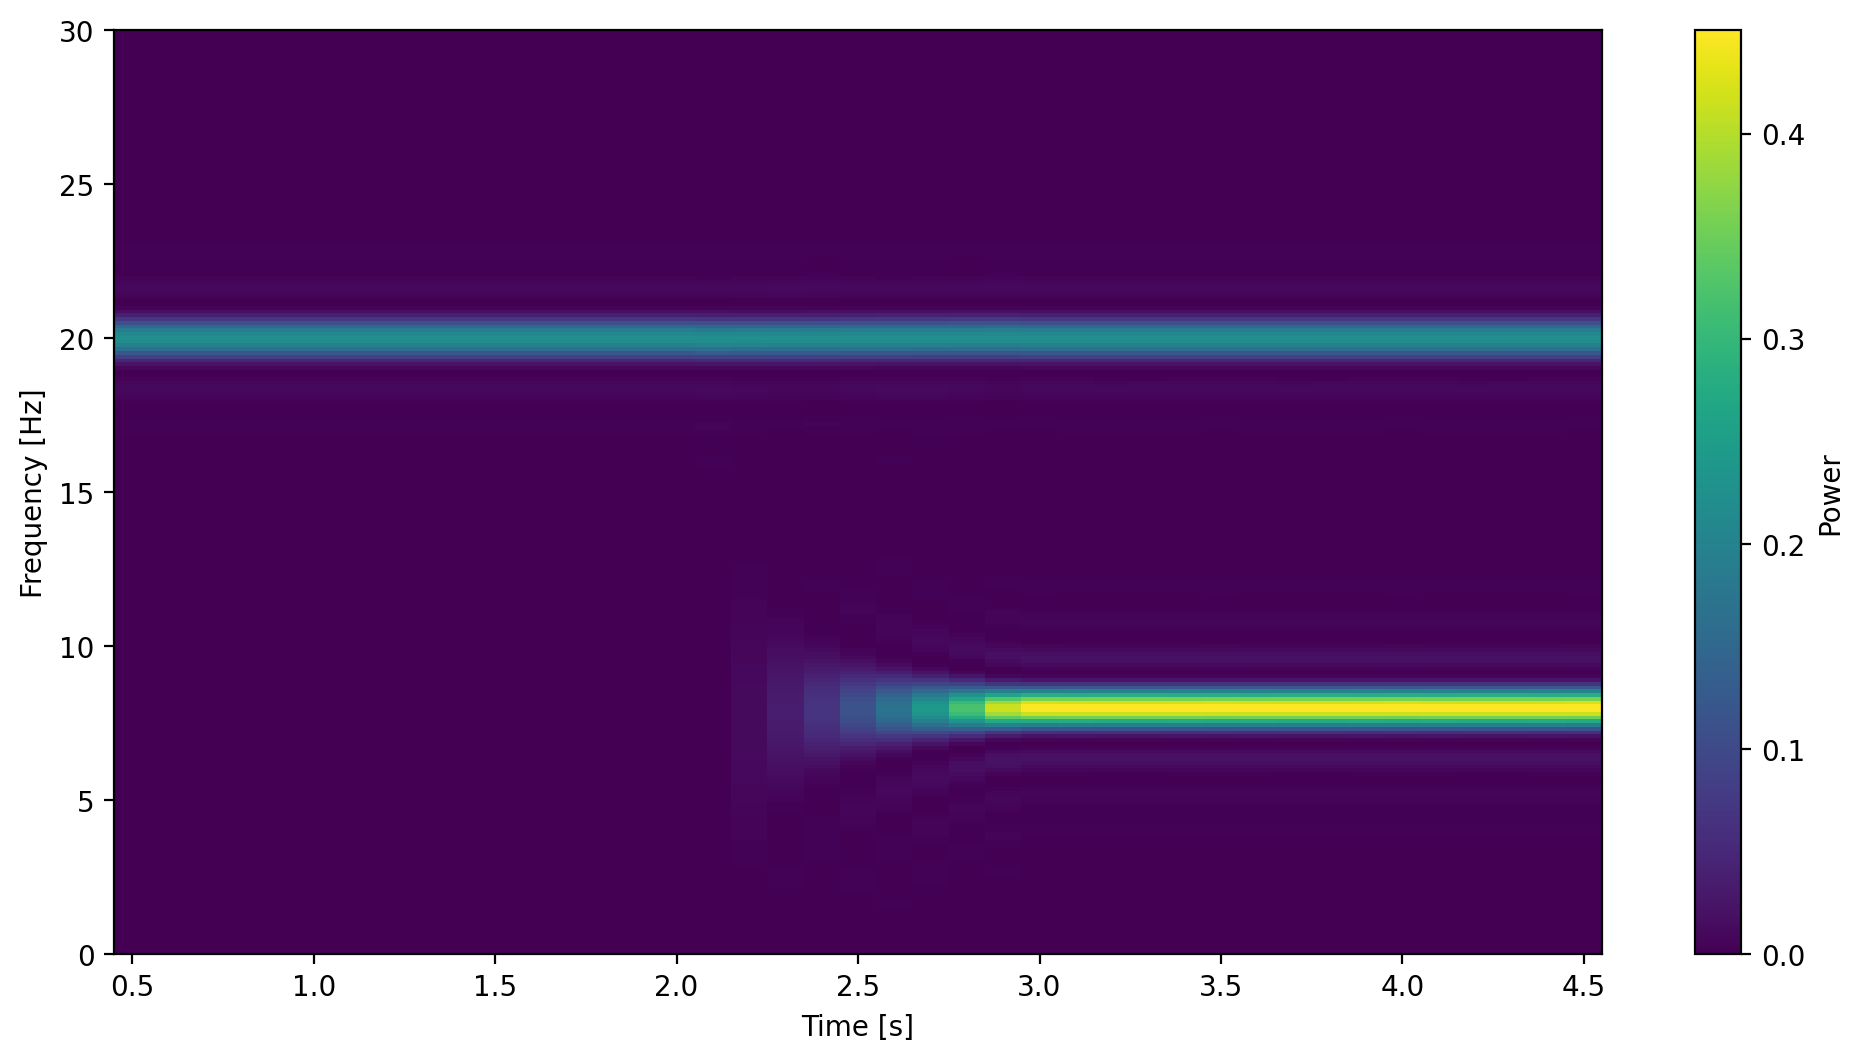

In [167]:
# Using the spectrogram function

# Define parameters for the spectrogram
window_length = 1*fs  # length of the window in seconds
overlap = 0.9*window_length  # overlap between consecutive windows
nfft = 2**13  # number of data points used in each block for the FFT

# Compute the spectrogram
F, T, Sxx = signal.spectrogram(LFP, fs, nperseg=int(window_length), noverlap=overlap, nfft=nfft)

# Visualize the spectrogram
plt.figure(figsize=(12,6))
plt.pcolormesh(T, F, Sxx)
plt.ylim([0,30])
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power');

---
# Section 4: Computing Phase Coherence

*Estimated timing to here from start of tutorial: 35 min*


In this section, we dive into the computation of phase coherence, a crucial measure in neuroscience for assessing the synchronization between different Local Field Potential (LFP) signals. Phase coherence provides valuable insights into the coordination of neural activity across multiple regions, shedding light on the underlying functional connectivity.

Let's explore the steps involved in computing phase coherence and gain a deeper understanding of its significance in the context of mesoscopic neural dynamics.


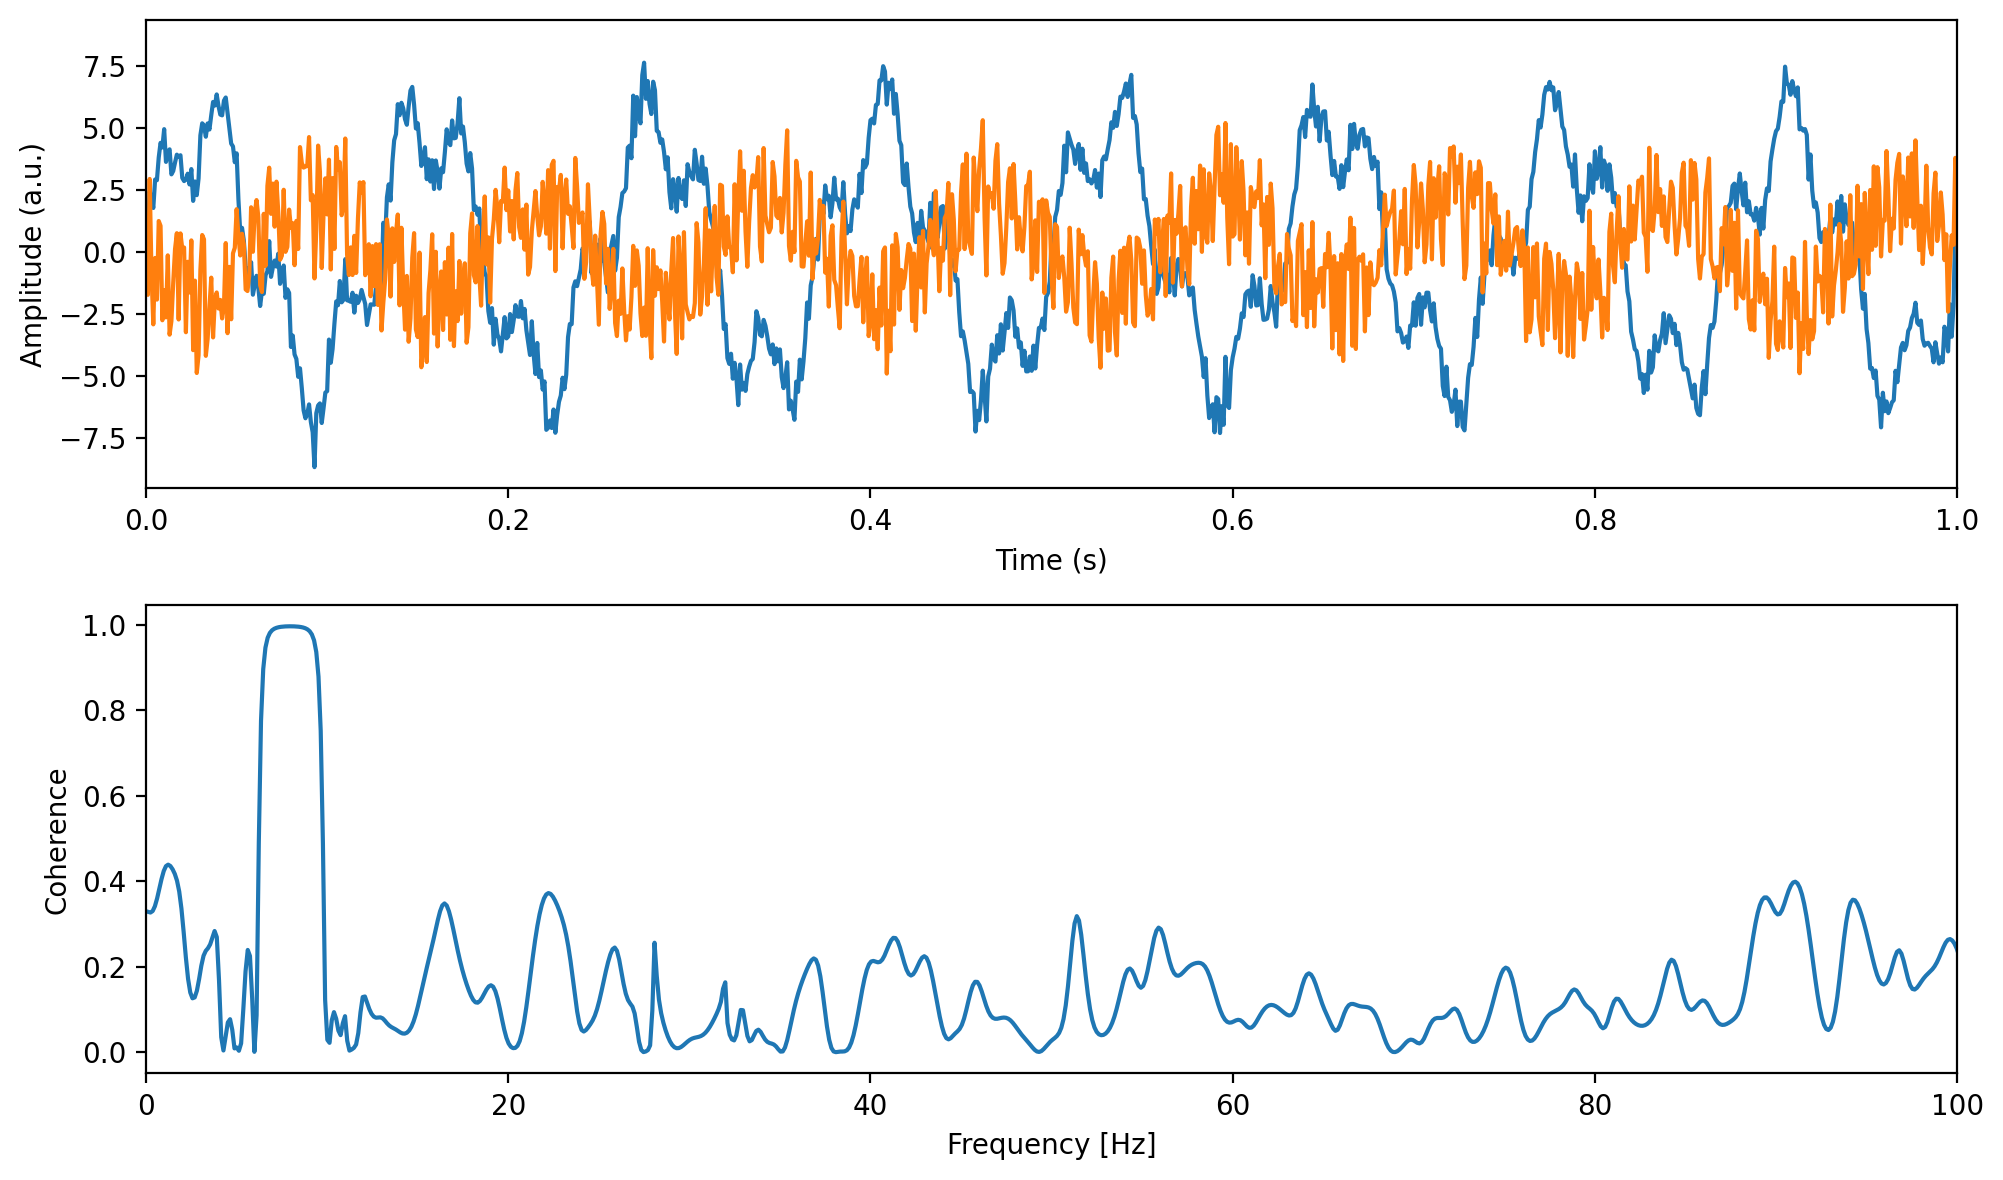

In [172]:
# Compute the coherence value for a single frequency

# Define the two frequencies
freq1 = 8
freq2 = 30
fs = 1000

# Generate random noise
noise = np.random.normal(0, 0.5, len(t)) # mean, SD, length

# Create the time vector
t = np.arange(0, 10, 1/fs)
phi   = -np.deg2rad(180) # Phase difference of 180 degrees
rand_phi = np.random.uniform(0, 2*np.pi, len(t)) # Random phase differences

# Create two signals
signal1 = 5* np.sin(2 * np.pi * freq1 * t) + 2 * np.sin(2*np.pi*freq2*t) + noise
# Added phase difference to the second frequency in signal2
signal2 = 2* np.sin(2 * np.pi * freq1 * t + phi) + 2 * np.sin(2*np.pi*freq2*t + rand_phi) + noise 

# Set parameters for the coherence function
noverlap = 0.5*fs # Amount of overlap between windows
nfft = 2**13 # Number of points to compute the FFT- the larger the better the frequency resolution
nperseg = window_length # Number of points per segment

# Compute the coherence between the two signals
frequencies, coherence = signal.coherence(signal1, signal2, fs=fs,
                                          nperseg=nperseg, noverlap=noverlap, nfft=nfft)

# Plot the signals
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, signal1)
plt.plot(t, signal2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.xlim([0, 1])

# Plot the coherence
plt.subplot(2, 1, 2)
plt.plot(frequencies, coherence)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.xlim([0, 100])
plt.tight_layout()
plt.show()


In [173]:
# @markdown Make sure you execute this cell to enable the widget!
@widgets.interact(noverlap=widgets.FloatSlider(0.5,min=0, max=1, step=0.1),
               nfft=widgets.IntSlider(1024, min=1024, max=2**15, step=1024),
               nperseg=widgets.IntSlider(1*fs, min=25, max=fs, step=1))


# Interactive function to compute and plot coherence
def interactive_coherence(noverlap, nfft, nperseg):
    # Compute the coherence between the two signals
    frequencies, coherence = signal.coherence(signal1, signal2, fs=fs,
                                              nperseg=nperseg, noverlap=noverlap, nfft=nfft)

    # Plot the signals
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(t, signal1)
    plt.plot(t, signal2)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (a.u.)')
    plt.xlim([0, 1])

    # Plot the coherence
    plt.subplot(2, 1, 2)
    plt.plot(frequencies, coherence)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Coherence')
    plt.xlim([0, 100])
    plt.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='noverlap', max=1.0), IntSlider(value=1024, descripti…

#### Coherence also varies in time

It's important to note that coherence, alongside the other signal properties we have explore until now, also exhibits temporal variations. Below is a example signal with varying levels of coherence in time.


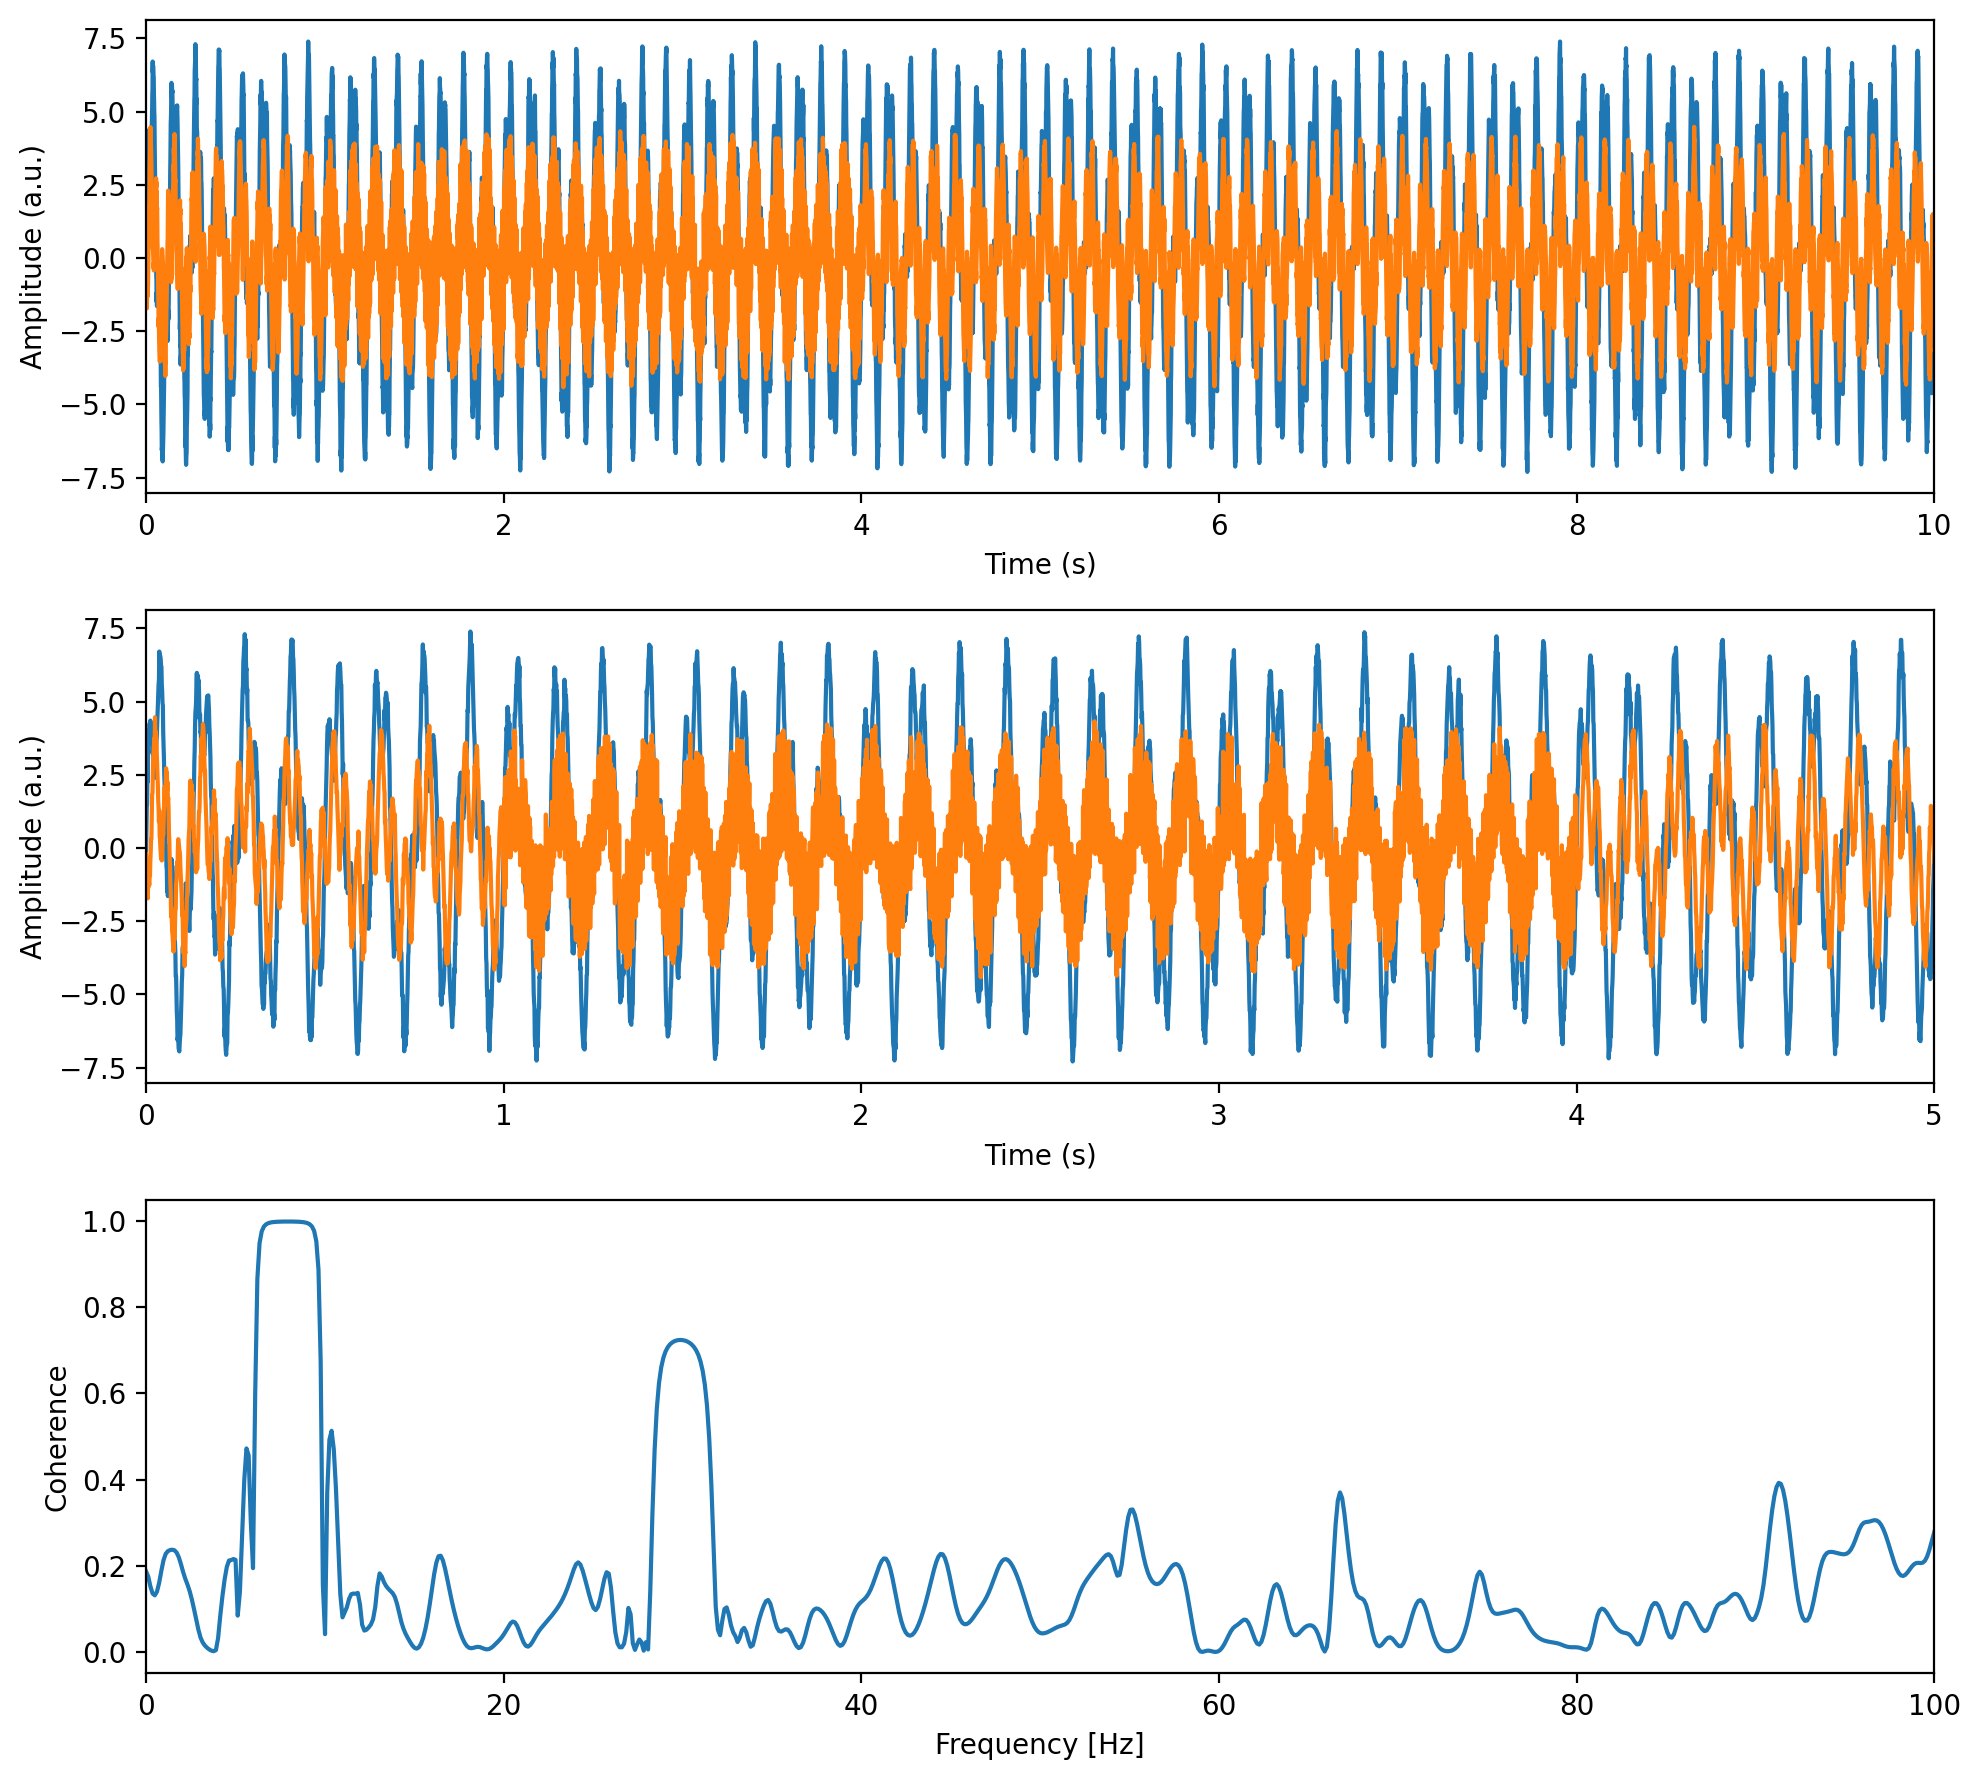

In [182]:
# Compute the coherence value for a single frequency

# Define the two frequencies
freq1 = 8
freq2 = 30
fs = 1000

# Create the time vector
t = np.arange(0, 10, 1/fs)

# Generate random noise
noise = np.random.normal(0, 0.2, len(t)) # mean, SD, length

# Phase difference of 180 degrees from seconds 1 to 4
phi = np.ones_like(t) * -np.deg2rad(180)
phi[(t >= 1) & (t < 4)] = np.random.uniform(0, 2*np.pi, len(t[(t >= 1) & (t < 4)]))
rand_phi = np.random.uniform(0, 2*np.pi, len(t)) # Random phase differences


# Create two signals
signal1 = 5* np.sin(2 * np.pi * freq1 * t) + 2 * np.sin(2*np.pi*freq2*t) + noise
signal2 = 2* np.sin(2 * np.pi * freq1 * t) + 2 * np.sin(2*np.pi*freq2*t + phi) + noise # Added phase difference to the second frequency in signal2

# Set parameters for the coherence function
noverlap = 0.5*fs # Amount of overlap between windows
nfft = 2**13 # Number of points to compute the FFT- the larger the better the frequency resolution
nperseg = window_length # Number of points per segment

# Compute the coherence between the two signals
frequencies, coherence = signal.coherence(signal1, signal2, fs=fs,
                                          nperseg=nperseg, noverlap=noverlap, nfft=nfft)


# Plot the signals
plt.figure(figsize=(10, 9))
plt.subplot(3, 1, 1)  # New subplot added
plt.plot(t, signal1)
plt.plot(t, signal2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.xlim([0, 10])  # Changed to show entire duration

plt.subplot(3, 1, 2)  # Original subplot
plt.plot(t, signal1)
plt.plot(t, signal2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.xlim([0, 5])


# Plot the coherence
plt.subplot(3, 1, 3)  # Original subplot
plt.plot(frequencies, coherence)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.xlim([0, 100])
plt.tight_layout()
plt.show()

#### Meet the coherogram

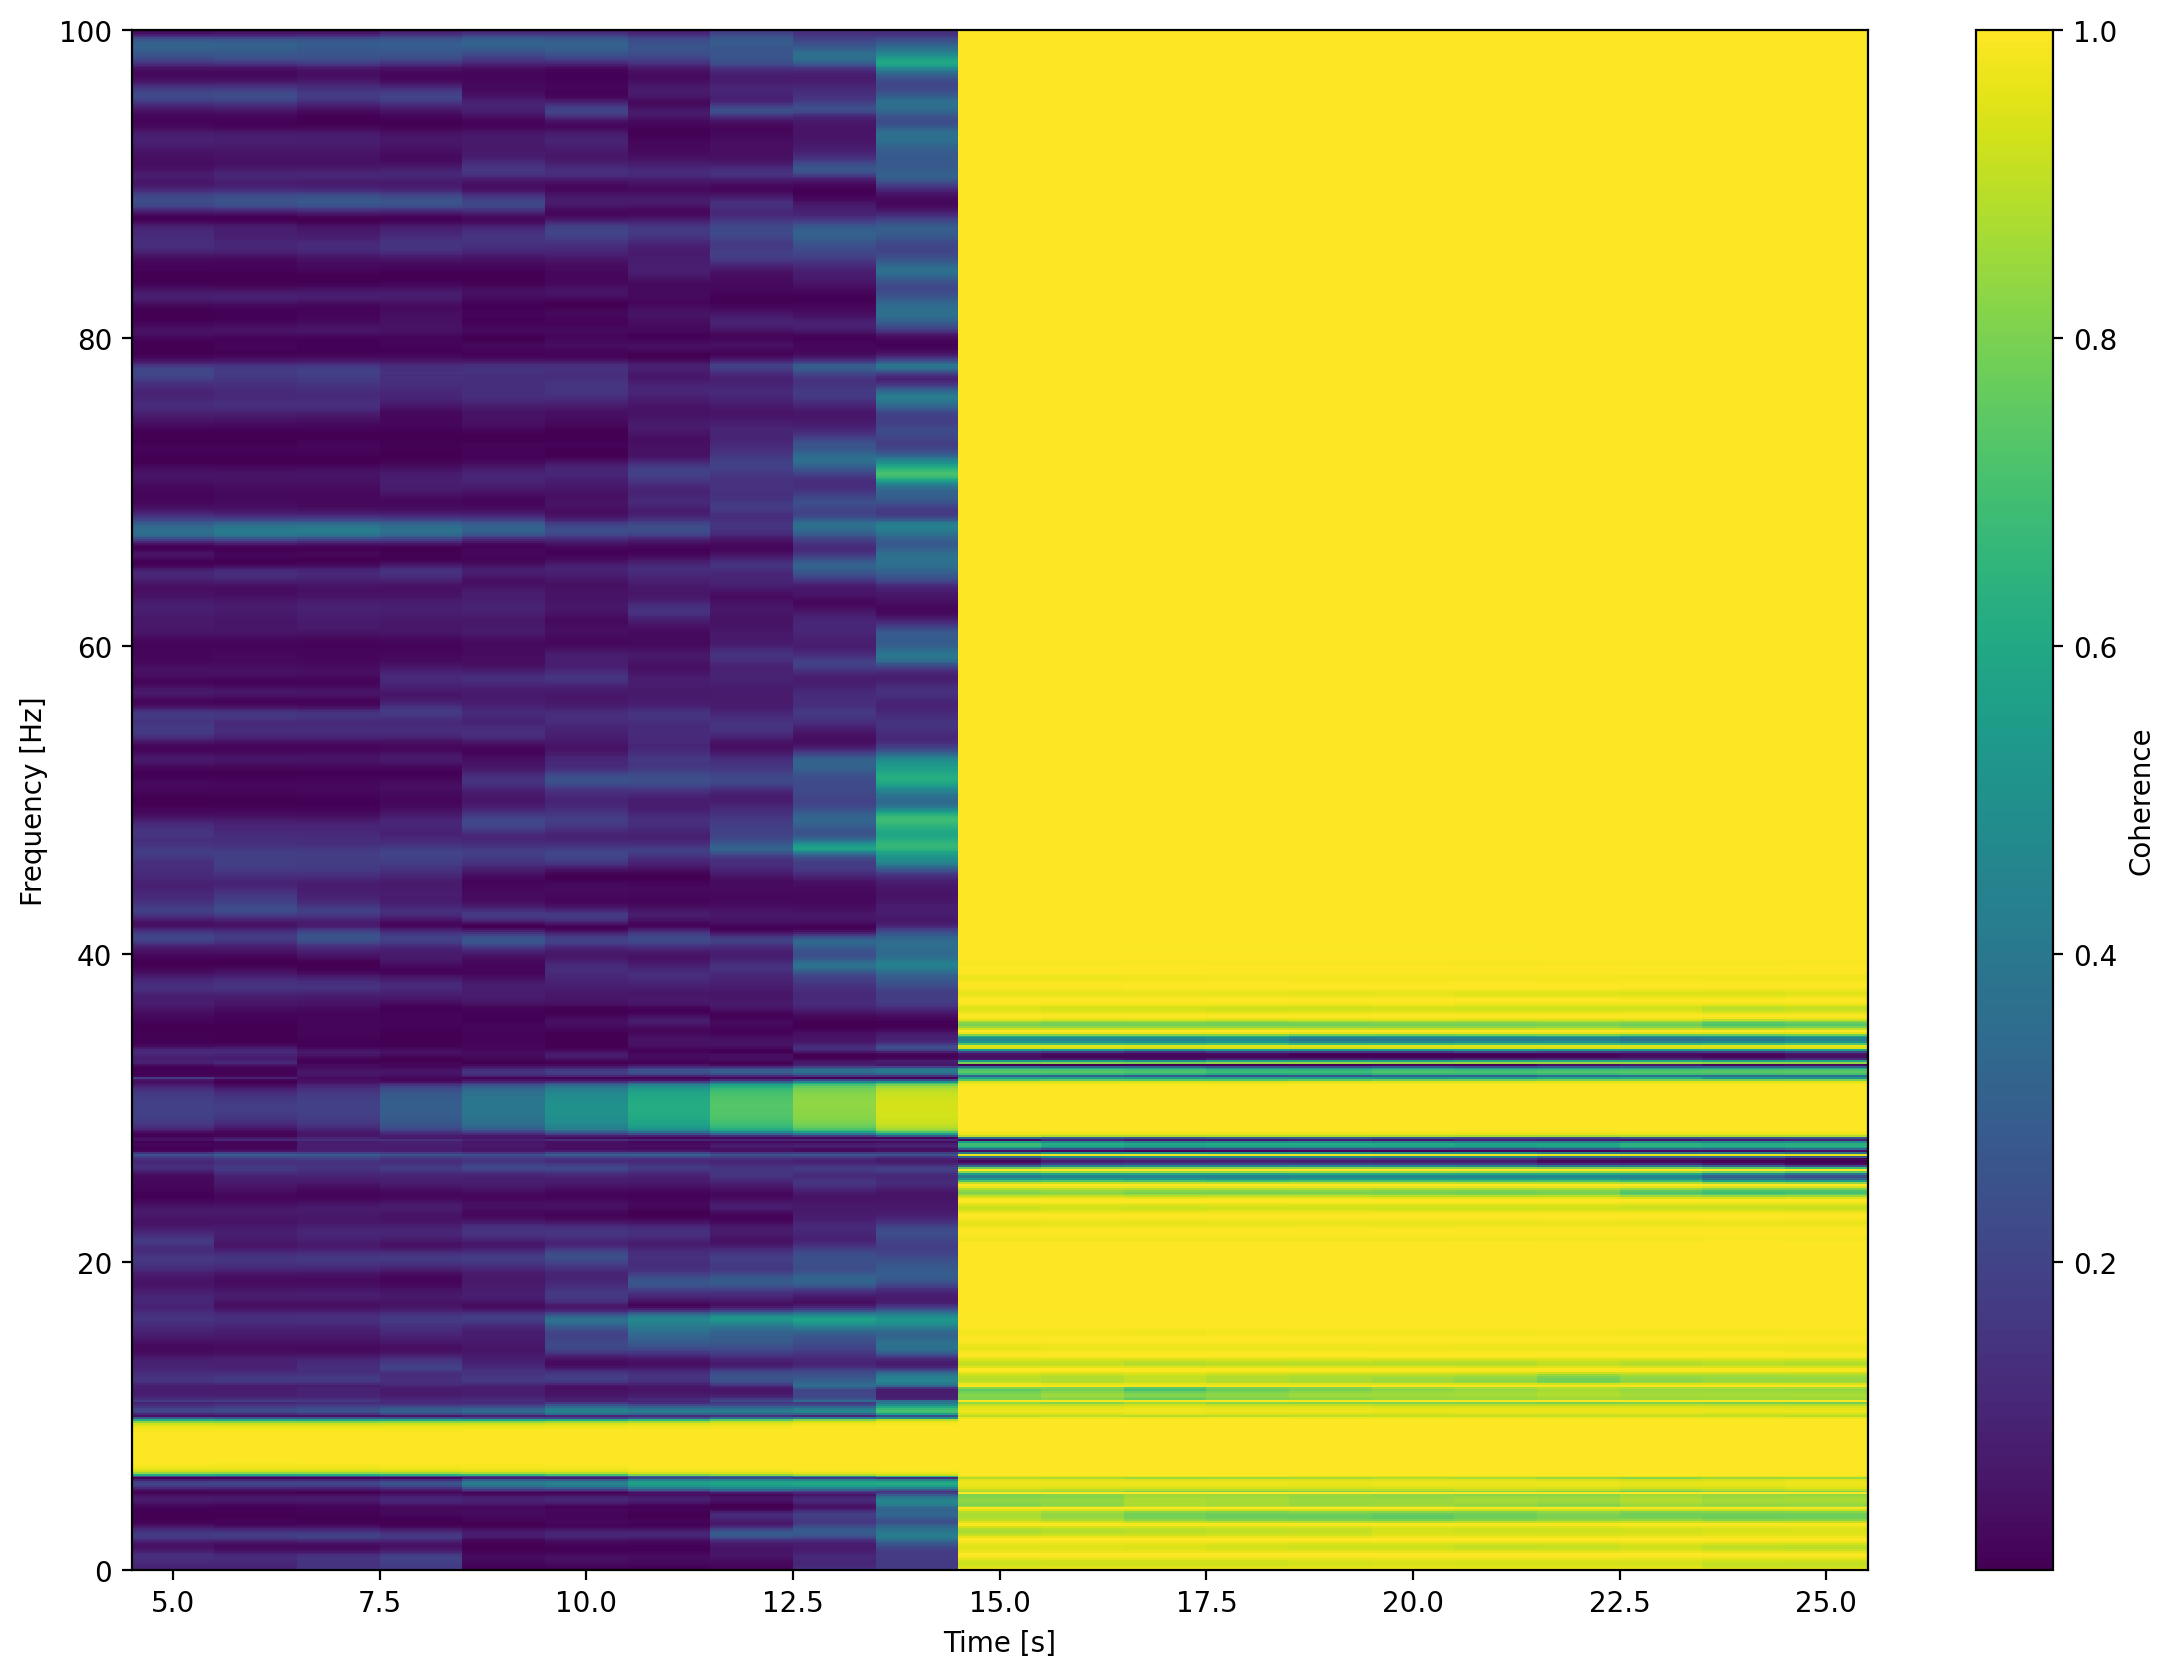

In [185]:
# Define the two frequencies
freq1 = 8
freq2 = 30
fs = 1000

# Create the time vector
t = np.arange(0, 30, 1/fs)

# Generate random noise
noise = np.random.normal(0, 0.2, len(t)) # mean, SD, length

# Phase difference of 180 degrees for the first 2 seconds and the last 10 seconds
phi = np.ones_like(t) * -np.deg2rad(180)
phi[(t >= 2) & (t < 10)] = np.random.uniform(0, 2*np.pi, len(t[(t >= 2) & (t < 10)]))
rand_phi = np.random.uniform(0, 2*np.pi, len(t)) # Random phase differences


# Create two signals
signal1 = 5* np.sin(2 * np.pi * freq1 * t) + 2 * np.sin(2*np.pi*freq2*t) + noise
signal2 = 2* np.sin(2 * np.pi * freq1 * t) + 2 * np.sin(2*np.pi*freq2*t + phi) + noise

#signal1 = 5* np.sin(2 * np.pi * freq1 * t) + 2 * np.sin(2*np.pi*freq2*t)
#signal2 = 2* np.sin(2 * np.pi * freq1 * t) + 2 * np.sin(2*np.pi*freq2*t + phi) # Added phase difference to the second frequency in signal2

# Set parameters for the coherence function
win    = 10*fs # window size
step   = 0.1*win # step size
Nwin   = int((len(signal1)-win)/step+1)
nfft   = 2**13
cohwin = 1*fs # window within Cxy computation

Coherogram = []  # Initialize an empty list to store the coherence values
T = []  # Initialize an empty list to store the time values
for nwin in range(Nwin):  # Iterate through the range of Nwin
    temp = np.arange(win)+nwin*int(step)  # Create a temporary array of indices for the current window
    F, Cxy = signal.coherence(signal1[temp],signal2[temp],fs=fs,nperseg=cohwin,nfft=nfft)  # Calculate coherence using the signals within the current window
    Coherogram.append(Cxy.T)  # Append the coherence values to the Coherogram list
    T.append(np.mean(temp/fs))  # Append the average time value for the current window to the T list

plt.figure(figsize=(14,10))
plt.pcolormesh(T,F,np.transpose(Coherogram))
plt.ylim([0,100])
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Coherence');


---
# Section 5: Calculating the Modulation Index between different frequencies

*Estimated timing to here from start of tutorial: 50 min*


Welcome to Section 5, where we explore the computation of the Modulation Index. This advanced analysis allows us to assess the interaction between signals of different frequencies, providing a nuanced perspective on how neural oscillations may modulate each other.

The Modulation Index serves as a valuable tool in unraveling the complexities of mesoscopic neural dynamics, offering insights into frequency-specific interactions and potential coordination between distinct neural circuits.

Let's delve into the steps of computing the Modulation Index and discover its relevance in advancing our understanding of the intricate interplay within the brain's local field potential data.

The file LFP_HG_HFO contains simultaneous recordings of 2 LFP channels positioned on two different hippocampal layers. These channels have been named lfpHG and lfgHFO.


In [ ]:
# Load the data
data = loadmat('LFP_HG_HFO.mat')
lfpHG = data['lfpHG'][0]
lfpHFO = data['lfpHFO'][0]

# Set the sampling rate and calculate the time vector
srate = 1000
dt = 1./srate
t = dt*(np.arange(len(lfpHG)))

# Define nyquist frequency
nyq = 0.5*srate

LFP = lfpHG  # Assign lfpHG to LFP for further processing

b,a = signal.butter(3,[5./nyq,10./nyq],'bandpass')  # Design a bandpass filter for the phase signal
filteredPhase = signal.filtfilt(b,a,LFP)  # Apply the bandpass filter to the LFP signal

b,a = signal.butter(3,[60./nyq,100./nyq],'bandpass')  # Design a bandpass filter for the amplitude signal
filteredAmp = signal.filtfilt(b,a,LFP)  # Apply the bandpass filter to the LFP signal

phase = np.angle(signal.hilbert(filteredPhase))  # Calculate the phase of the filtered phase signal
amp = abs(signal.hilbert(filteredAmp))  # Calculate the amplitude of the filtered amplitude signal

# Associated indices for each phase bin
I = (np.rad2deg(phase)>-180)*(np.rad2deg(phase)<-160)  # Define indices for a specific phase range

plt.figure(figsize=(16,10))  # Create a new figure with a specific size
plt.subplot(211)  # Create a subplot in a 2x1 grid for the first plot
plt.plot(t,LFP,'k-')  # Plot the LFP signal
plt.plot(t,filteredPhase-1,linewidth=2)  # Plot the filtered phase signal
plt.plot(t,8*filteredAmp-1.9,linewidth=1)  # Plot the filtered amplitude signal
plt.plot(t,8*amp-1.9,'C1',linewidth=2)  # Plot the amplitude signal
plt.xlim(40,42)  # Set the x-axis limits
plt.ylim(-3,1)  # Set the y-axis limits

plt.subplot(212)  # Create a subplot in a 2x1 grid for the second plot
plt.plot(t,phase,'C0.')  # Plot the phase signal
plt.plot(t[I],phase[I],'r.')  # Highlight the phase within the specified range
plt.xlim(40,42)  # Set the x-axis limits
plt.xlabel('Time (s)',size=13)  # Set the x-axis label
plt.yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],['-$\pi$','-$\pi$/2',0,'$\pi$/2','$\pi$'])  # Set the y-axis ticks

plt.subplot(211)  # Create a subplot in a 2x1 grid for the third plot
plt.plot(t[I],8*amp[I]-1.9,'r.')  # Highlight the amplitude within the specified range
plt.yticks([-0.5,0,0.5])  # Set the y-axis ticks
plt.title('Mean Amplitude = '+str(np.mean(amp[I])),size=14)  # Set the title for the plot
plt.show()

In [ ]:
# Mean amplitude for each phase bin

# Define the phase vector
phasevector = np.arange(-180,161,20)

# Initialize an empty array for mean amplitude
MeanAmp = np.empty(len(phasevector))

# Calculate the mean amplitude for each phase bin
for count,phasebin in enumerate(phasevector):
    I = (np.rad2deg(phase)>phasebin)*(np.rad2deg(phase)<phasebin+20)
    MeanAmp[count] = np.mean(amp[I])

# Create a bar plot to visualize the mean amplitude
plt.figure(figsize=(10,6))
plt.bar(np.arange(10,711,20),np.concatenate((np.array(MeanAmp),np.array(MeanAmp))),
        20,color='r',edgecolor='k')
plt.xticks(np.arange(0,721,90))
plt.xlabel('Theta Phase (^o)',size=13)
plt.ylabel('Mean $\gamma$ Amplitude (mV)',size=13)
plt.xlim(0,720)

# Calculate the entropy-based modulation index
p = MeanAmp/sum(MeanAmp)
H = -sum(p[p>0]*np.log(p[p>0]))
N = len(MeanAmp)
MI = (np.log(N)-H)/np.log(N)
plt.title('Modulation Index = '+str(MI),size=14);

In [ ]:
# Phase-Amplitude comodulogram
LFP = lfpHG

phase_freq_vector = np.arange(1.,20.,2.)
fp_bandwidth = 4
amp_freq_vector = np.arange(20.,201.,5.)
fa_bandwidth = 10

MeanAmp = np.empty(len(phasevector))  # Initialize an empty array for mean amplitude
Comodulogram = np.empty((len(phase_freq_vector),len(amp_freq_vector)))  # Initialize an empty array for the comodulogram

for count_phase,fp in enumerate(phase_freq_vector):  # Loop through the phase frequency vector
    b,a = signal.butter(3,[fp/nyq,(fp+fp_bandwidth)/nyq],'bandpass')  # Apply a Butterworth filter to the phase signal
    filteredPhase = signal.filtfilt(b,a,LFP)  # Filter the LFP signal
    phase = np.angle(signal.hilbert(filteredPhase))  # Calculate the phase of the filtered signal

    for count_amp,fa in enumerate(amp_freq_vector):  # Loop through the amplitude frequency vector
        b,a = signal.butter(3,[fa/nyq,(fa+fa_bandwidth)/nyq],'bandpass')  # Apply a Butterworth filter to the amplitude signal
        filteredAmp = signal.filtfilt(b,a,LFP)  # Filter the LFP signal
        amp = abs(signal.hilbert(filteredAmp))  # Calculate the amplitude of the filtered signal

        for count,phasebin in enumerate(phasevector):  # Loop through the phase vector
            I = (np.rad2deg(phase)>phasebin)*(np.rad2deg(phase)<(phasebin+20))  # Define the index for the specified phase range
            MeanAmp[count] = np.mean(amp[I])  # Calculate the mean amplitude within the specified phase range

        p = MeanAmp/sum(MeanAmp)  # Calculate the probability distribution
        MI = (np.log(len(p))+sum(p[p>0]*np.log(p[p>0])))/np.log(len(p))  # Calculate the modulation index
        Comodulogram[count_phase,count_amp] = MI  # Store the modulation index in the comodulogram array


In [ ]:
plt.figure(figsize=(10,7))
plt.contourf(phase_freq_vector+fp_bandwidth/2.,amp_freq_vector+fa_bandwidth/2.,Comodulogram.T,30)
plt.xlabel('Phase Frequency (Hz)',size=13)
plt.ylabel('Amplitude Frequency (Hz)',size=13)
plt.colorbar(label="Modulation Index");

---
# Summary


Congratulations on completing this micro-course on local field potential (LFP) analysis with open-source tools! Throughout this notebook, we delved into the fundamental aspects of signal processing and oscillation analyses in neuroscience. Let's recap the key highlights:

## Key Learnings:

1. **Visualizing Raw Signals and Identifying Artifacts:**
   - Explored techniques for visualizing raw LFP signals and detecting artifacts that could impact subsequent analyses.

2. **Transforming Signals: Temporal to Frequency Domain:**
   - Mastered the transformation of temporal LFP signals into the frequency domain, gaining insights into the spectral composition of neural activity.

3. **Computing Time-Frequency Profiles (Spectrogram):**
   - Learned to compute spectrograms, revealing the dynamic changes in spectral power over time and providing a comprehensive view of neural oscillations.

4. **Calculating Phase Coherence Between Signals:**
   - Explored the computation of phase coherence, a vital measure for understanding synchronization between different LFP signals.

5. **Determining Modulation Index Between Signals of Different Frequencies:**
   - Investigated advanced analyses by calculating modulation indices between signals of distinct frequencies, uncovering intricate interactions in neural circuits.


## Next Steps:

This micro-course serves as a foundation for further exploration into the vast field of neuroscientific signal analysis. Consider applying these principles to real-world datasets and extending your knowledge into more advanced topics such as connectivity analysis, feature extraction, and machine learning applications in neuroscience.


---
# Supplementary Materials

## Databases:

Explore openly available neural electrophysiology data from various websites for your research:

- [CRCNS](crcns.org)
- [IBL's Brainwide Map](https://www.internationalbrainlab.com/data)
- [Zenodo](https://zenodo.org)
- [figshare](figshare.com)
- [Dryad](https://datadryad.org/stash)
- [Google Dataset Search](https://datasetsearch.research.google.com)

## Resources from the Open-Source Community:

Discover valuable resources from the open-source community related to neuroscience:

- [List of Neuroscience Databases](en.wikipedia.org/wiki/List_of_neuroscience_databases)
- [NeuralEnsemble](http://neuralensemble.org)
- [Open Computational Neuroscience Resources](https://github.com/asoplata/open-computational-neuroscience-resources)

## Learning Materials:

Enhance your knowledge with these learning materials:

- [Analyzing Neural Time Series Data: Theory and Practice (Mike Cohen's book)](https://direct.mit.edu/books/book/4013/Analyzing-Neural-Time-Series-DataTheory-and)
- [Mike X Cohen YT videos on signal processing for neuroscience](https://www.youtube.com/@mikexcohen1/playlists)
- [Signal Analysis 2020.2 (Prof. Tort's Signal Analysis course repo on GitHub)](https://github.com/tortlab/SignalAnalysis2020.2)
